# Module imports, function definitions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  # local install? run 'matplotlib tk'
import matplotlib.dates as dt

import pathlib  # used for compatibility with non-POSIX systems
import datetime
import time
import urllib.request
import os
import IPython
import IPython.display



from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns

use_tpu = True
if  use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'No TPU; did you request one?'
if 'COLAB_TPU_ADDR' in os.environ:
    TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
    TF_MASTER=''
tpu_address = TF_MASTER
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)


def import_omni_month(year, month, resolution='1min', cols='All'):
    """
    Finds local OMNI Data files, if not available attempts to download.
    Downloads files from
    https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/monthly_1min/
    Rules of the road at https://omniweb.sci.gsfc.nasa.gov/html/citing.html
    
    Parameters
    ----------
        year: the year of the data to import
        month: the month of the data to import
        resolution: 1min or 5min (only 1min implemented)
    
    Returns
    -------
        data: a pandas DataFrame object.
    
    Author: Andy Smith
    Updated: Ross Dobson, August 2020
    """

    # get string version of the year and month to use in the filenames
    year_str = str(year)
    if month < 10:
        month_str = '0'+str(month)  # needs to be e.g. "05" not "5"
    else:
        month_str = str(month)

    leap_year = leapcheck(year)  # is it a leap year (is feb 28 or 29 days)

    # List end day for each month so we can cycle through
    month_end_dates = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    if leap_year:
        month_end_dates[1] = 29  # feb now has 29 as leap year

    # make datetime objects. End needs to be 23:59:59 to get all of last day
    start_datetime = datetime.datetime(year, month, 1)
    end_datetime = datetime.datetime(year, month, month_end_dates[(month-1)],
                                     23, 59, 59)

    # See https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/hroformat.txt
    omni_header = ['Year', 'Day', 'Hour', 'Minute', 'B_IMF_ScID',
                   'Plasma_ScID', 'IMFAvPoints', 'PlasmaAvPoints',
                   'PercentInterp', 'Timeshift', 'RMSTimeshift',
                   'RMSPhaseFrontNormal', 'TimeBetweenObs', 'B', 'B_X_GSM',
                   'B_Y_GSE', 'B_Z_GSE', 'B_Y_GSM', 'B_Z_GSM', 'RMSBScalar',
                   'RMSFieldVector', 'V', 'V_X_GSE', 'V_Y_GSE', 'V_Z_GSE',
                   'n_p', 'T', 'P', 'E', 'Beta', 'AlfvenMachff', 'X_SC_GSE',
                   'Y_SC_GSE', 'Z_SC_GSE', 'X_BSN_GSE', 'Y_BSN_GSE',
                   'Z_BSN_GSE', 'AE', 'AL', 'AU', 'SymD', 'SymH', 'AsyD',
                   'AsyH', 'PCN', 'MagnetosonicMach', '10MeVProton',
                   '30MeVProton', '60MeVProton']

    # Use pickles, MUCH faster than the .asc files
    pkl_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/pkl')

    mon_str = str(month)
    if (month < 10):
        mon_str = '0' + str(month)

    pkl_fname = str(year) + mon_str + '.pkl'
    pkl_path = pkl_dir / pkl_fname

    # Look for the pickle
    try:
        data = pd.read_pickle(pkl_path)
        print("Pickle found:", pkl_fname)

    except FileNotFoundError:
        print("Pickle not found. Looking for local .asc files to create it.")

        # Check if already downloaded because these files are big
        asc_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/asc')
        asc_fname = 'OMNI_1min_' + year_str + month_str + '.asc'
        asc_path = asc_dir / asc_fname
        try:
            # headers are NOT stored in the NASA asc data files, so header=None
            # instead, manually passed in via 'names'. Not ideal, but it works
            data = pd.read_csv(asc_path, sep='\s+',
                               names=omni_header, header=None)
            print('Local data found at', asc_path)

            # not entirely sure what this is doing - just generating the
            # column of datetimes to use as the index?
            data['DateTime'] = data.apply(
                lambda row:
                datetime.datetime(int(row.Year), 1, 1)
                + datetime.timedelta(
                    days=int(row.Day) - 1)
                + datetime.timedelta(seconds=row.Hour*60*60 + row.Minute*60),
                axis=1)

        # FileNotFoundError from pd.read_csv means we need to download the data
        except FileNotFoundError:

            print('Local .asc not found -> '
                  + 'downloading from https://spdf.sci.gsfc.nasa.gov')
            asc_url = ('https://spdf.sci.gsfc.nasa.gov/pub/data/omni/'
                       + 'high_res_omni/monthly_1min/omni_min'
                       + year_str + month_str + '.asc')

            print('Creating local directory at ', asc_dir,
                  ' (if it doesn\'t already exist)')
            pathlib.Path(asc_dir).mkdir(exist_ok=True)

            print('Done. Downloading data to: ', asc_path)
            urllib.request.urlretrieve(asc_url, asc_path)  # Saves to asc_path
            print('Data downloaded.')

        # headers NOT in data, passed in via 'names' parameter instead
        data = pd.read_csv(asc_path, sep='\s+',
                           names=omni_header, header=None)

        # same as above, think it just generates datetimes
        data['DateTime'] = data.apply(
            lambda row:
            datetime.datetime(int(row.Year), 1, 1)
            + datetime.timedelta(days=int(row.Day) - 1)
            + datetime.timedelta(seconds=row.Hour*60*60+row.Minute*60),
            axis=1)

        # Select the data within our time range
        data = data[(data.DateTime >= start_datetime)
                    & (data.DateTime <= end_datetime)]

        # Bodge broken data with NaN, easier to interpolate, pd is happier
        data = data.replace(99.99, np.nan)
        data = data.replace(999.9, np.nan)
        data = data.replace(999.99, np.nan)
        data = data.replace(9999.99, np.nan)
        data = data.replace(99999.9, np.nan)
        data = data.replace(9999999., np.nan)

        # Make DateTime the index of the dataframe - ie the row labels
        data.index = data['DateTime']

        # In case we only wanted specific columns
        if cols != 'All':
            data = data[cols]

        # store as pickle - MUCH faster loading, saves us doing this again
        data.to_pickle(pkl_path)

    return data

def leapcheck(year):
    '''Calculate whether the year is a leap year, return a True/False.
    TBH I based this off psuedo-code from Wikipedia.
    Args:
      year: Integer of the year to check
    Returns:
      A boolean True/False on whether the year is a leap year.
    '''
    leap_year = False
    if(year % 4 != 0):  # has to be divisible by 4
        leap_year = False
    elif(year % 100 == 0):
        if(year % 400 == 0):  # year XX00 isn't leap unless multiple of 400
            leap_year = True
        else:
            leap_year = False
    else:
        leap_year = True

    return leap_year

def import_omni_year(year):
    """Uses import_omni_month but concatenates it into an entire year.
    See the dosctring for import_omni_month above.
    Args:
      year: the year of data to get
    Returns:
      data: a pandas DataFrame object containing the year of data.
    """

    # Use pickles, MUCH faster than the .asc files
    pkl_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/pkl')
    pkl_fname = str(year) + '.pkl'
    pkl_path = pkl_dir / pkl_fname

    # Look for the pickle
    try:
        year_df = pd.read_pickle(pkl_path)
        print("Pickle found:", pkl_fname)

    except FileNotFoundError:
        print("Pickle not found. Looking for local .asc files to create it.")

        # load in each month with import_omni_month, store the df in array
        df_array = []
        for i in range(0, 12):  # as 0->11, we need to use i+1 for months
            this_month_df = import_omni_month(year, (i+1))
            df_array.append(this_month_df)

        # concat all the month's into one df
        year_df = pd.concat(df_array)

        # store as pickle - MUCH faster loading, saves us doing this again
        year_df.to_pickle(pkl_path)

    return year_df

def import_storm_week(year, month, day):
    """
    Imports the week of data surrounding a storm.
    Can deal with storms spanning month boundary as imports multiple months.
    Args:
        year: the year of the data to import
        month: the month of the data to import
    Returns:
        data: a pandas DataFrame object.
    Ross Dobson, September 2020
    """

    df_array = []
    for i in range(month-1, month+2):
        if (i == 13):
            this_month_df = import_omni_month(year+1, 1)
        elif (i == 0):
            this_month_df = import_omni_month(year-1, 12)
        else:
            this_month_df = import_omni_month(year, i)

        df_array.append(this_month_df)

    # concat the three months together into one df
    storm_df = pd.concat(df_array)

    # storm datetime - START of storm
    storm_dt = datetime.datetime(year, month, day)
    # start datetime -3 days
    start_dt = storm_dt - datetime.timedelta(days=3)
    # end datetime +4 days
    end_dt = storm_dt + datetime.timedelta(days=4)
    # this way we get 3 days either side
    storm_df = storm_df[(storm_df.DateTime >= start_dt)
                        & (storm_df.DateTime <= end_dt)]

    return storm_df

def storm_interpolator(my_df):
    """Straight-line interpolates gaps (NaNs) less than 15 minutes.
    After that, it just removes any remaining NaNs inplace."""
    # df_resampled = my_df.resample(
    #     '1T', loffset=datetime.timedelta(seconds=30.)).mean()
    df_resampled = my_df.interpolate(method='linear', limit=15)
    df_resampled.dropna(axis='index', how='any', inplace=True)

    return df_resampled

def storm_chunker(y_true, y_pred, y_pers, resolution='1h'):
    """
    Splits the storm into chunks of timesteps (1h and 6h implemented)
    If there's any gaps due to removed NaNs, it just means that hour will
    have slightly less datapoints in it. E.g. the borders of the chunk will
    still be 60 minutes apart, if not 60 datapoints apart.
    Args:
      y_true: the AL of true (discretized) AL to compare against
      y_pred: the predicted values of AL from the model
      y_pers: the persistence/AL history values
    Returns:
      chunks: array of 3-col dfs, each col is true, pred, pers
    Author:
      Ross Dobson 2020-10-06
    """


    first_dt = y_true.index[0]  # start_dt cannot precede this 
    limit_dt = y_true.index[-1]  # end_dt cannot exceed this

    year = int(first_dt.strftime("%Y"))
    month = int(first_dt.strftime("%m"))
    day = int(first_dt.strftime("%d"))
    hour = int(first_dt.strftime("%H"))

    # set it to the first (hopefully) full hour
    if (resolution == '1h'):
        start_dt = datetime.datetime(year, month, day, hour, 0)
        end_dt = start_dt + datetime.timedelta(minutes=59)
        interval = 1

    elif (resolution == '6h'):
        start_dt = datetime.datetime(year, month, day, hour, 0)
        end_dt = start_dt + datetime.timedelta(hours=5, minutes=59)
        interval = 6

    else:
        raise ValueError('This resolution', resolution, 'is not implemented.')

    chunks = []
    while (end_dt <= limit_dt):

        # get the chunk
        true_chunk = y_true.loc[start_dt:end_dt]
        pers_chunk = y_pers.loc[start_dt:end_dt]
        pred_chunk = y_pred.loc[start_dt:end_dt]

        # make one df for all three, append
        chunks.append(pd.concat(
            [true_chunk, pred_chunk, pers_chunk], axis=1, sort=False))

        # by iterating hours=1, we keep the XX:00 -> XX:59 spacing intact
        start_dt += datetime.timedelta(hours=interval)
        end_dt += datetime.timedelta(hours=interval)

    # now that every chunk for this storm is generated, return
    return chunks

def storm_metrics(y_true, y_pred, y_pers):
        """Runs various regression metrics from sklearn.metrics
        Args:
          y_true: The target values of discrete rolled-left AL
          y_pred: The predicted values of discrete rolled-left AL from model
          y_pers: The persistence (rolled-right) time history of AL
        Returns:
          None
        """

        # Explained variance score (higher is better, best 1.0)
        evs_true = explained_variance_score(y_true, y_pred)
        evs_pers = explained_variance_score(y_true, y_pers)

        # Mean absolute error (lower is better, best 0.0)
        mean_true = mean_absolute_error(y_true, y_pred)
        mean_pers = mean_absolute_error(y_true, y_pers)

        # Mean squared error (lower is better, best 0.0)
        mse_true = mean_squared_error(y_true, y_pred)
        mse_pers = mean_squared_error(y_true, y_pers)

        # not too affected by outliers - good choice of metric?
        # Median absolute error (lower is better, best 0.0)
        medi_true = median_absolute_error(y_true, y_pred)
        medi_pers = median_absolute_error(y_true, y_pers)

        # variance is dependent on dataset, might be a pitfall
        # R2 coefficient of determination (higher=better), best 1.0
        r2_true = r2_score(y_true, y_pred)
        r2_pers = r2_score(y_true, y_pers)

        return evs_true, evs_pers, mean_true, mean_pers, mse_true, mse_pers, medi_true, medi_pers, r2_true, r2_pers

def med_abs_err(y_true, y_pred, y_pers):
        """Runs MAE metric from sklearn.metrics
        Args:
          y_true: The target values of discrete rolled-left AL
          y_pred: The predicted values of discrete rolled-left AL from model
          y_pers: The persistence (rolled-right) time history of AL
        """

        # not too affected by outliers - good choice of metric?
        # Median absolute error (lower is better, best 0.0)
        medi_true = median_absolute_error(y_true, y_pred)
        medi_pers = median_absolute_error(y_true, y_pers)

        return medi_true, medi_pers

metrics = ["Explained variance score",
            "Mean absolute error",
            "Mean squared error",
            "Median absolute error",
            "R2 score"]

metrics_desc = ["higher is better, best 1.0",
                "lower is better",
                "lower is better",
                "lower is better",
                "higher is better, best 1.0"]

INFO:tensorflow:Initializing the TPU system: grpc://10.2.59.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.2.59.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# New section

In [ ]:
# Matplotlib commands sometimes need to be run in their own cell/run twice
mpl.rcParams['figure.figsize'] = (10, 8)
# mpl.rcParams['axes.grid'] = False

# Main loop: set up 2003 data and test storms

Pickle found: 2003.pkl
All 2003 data has been loaded.

2003 features have been scaled.
2003 AL has been scaled.

2003 features interpolated.

Folding the data (cross-validation):
Fold 1 ...
Fold 2 ...
Fold 3 ...
Fold 4 ...
Fold 5 ...
Folding complete.

Linear Regression R^2 score (best 1.0) 0.7251328091787501

Importing the validation storms:
Pickle found: 200611.pkl
Pickle found: 200612.pkl
Pickle found: 200701.pkl
Pickle found: 200107.pkl
Pickle found: 200108.pkl
Pickle found: 200109.pkl
Pickle found: 200507.pkl
Pickle found: 200508.pkl
Pickle found: 200509.pkl
Pickle found: 201003.pkl
Pickle found: 201004.pkl
Pickle found: 201005.pkl
Pickle found: 201107.pkl
Pickle found: 201108.pkl
Pickle found: 201109.pkl
Validation storms imported successfully.

Validation storm features and AL have been scaled.

Test storms interpolated.

Chunking storms:
Chunking the week around storm 2006-12-14 12:00 to 2006-12-16 00:00
Chunking the week around storm 2001-08-31 00:00 to 2001-09-01 00:00
Chunki

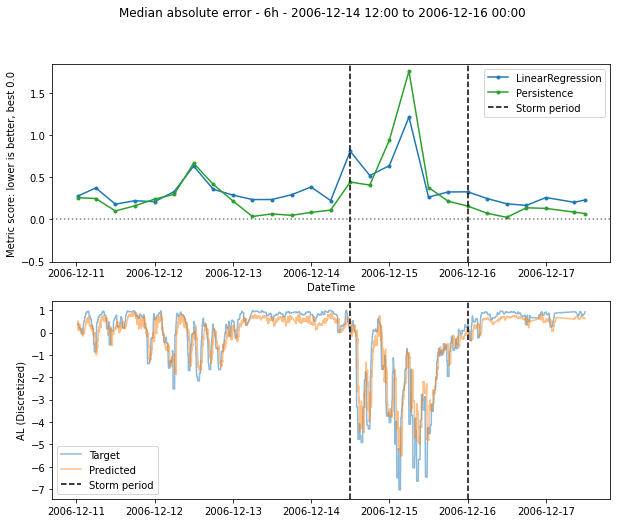

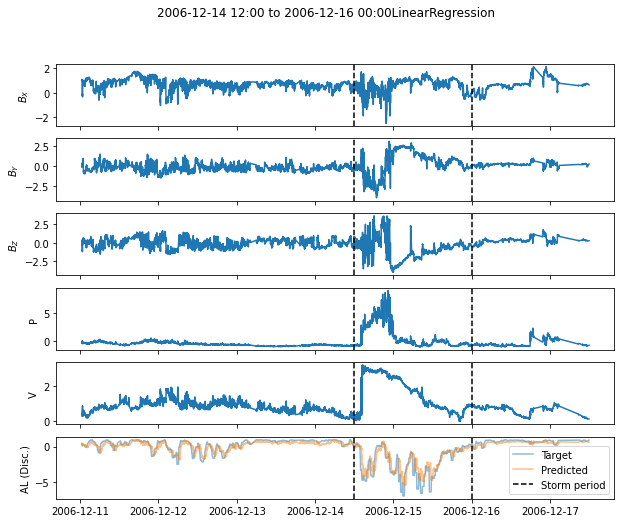

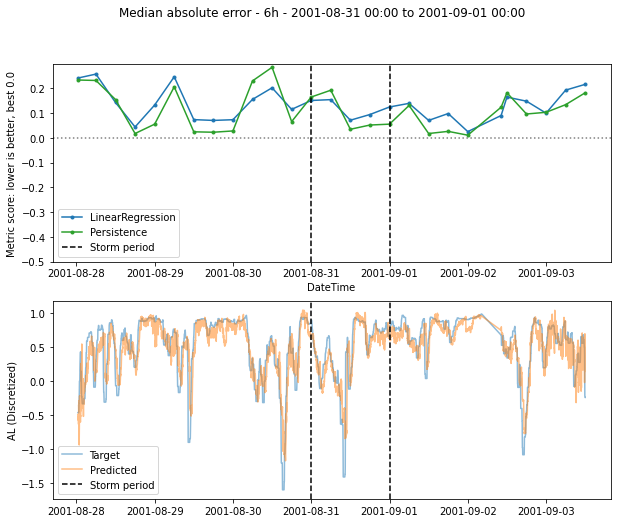

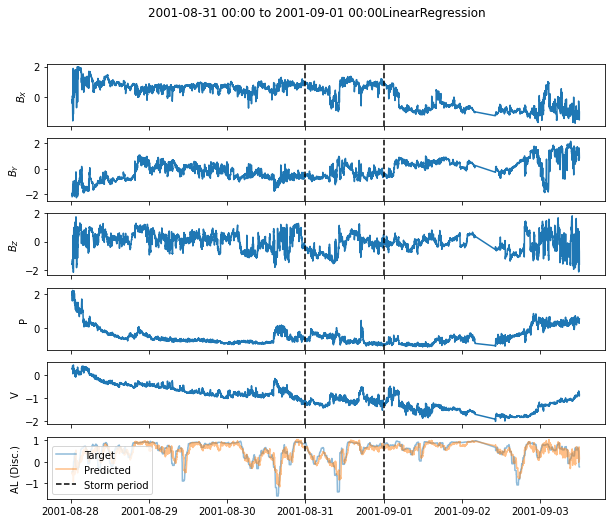

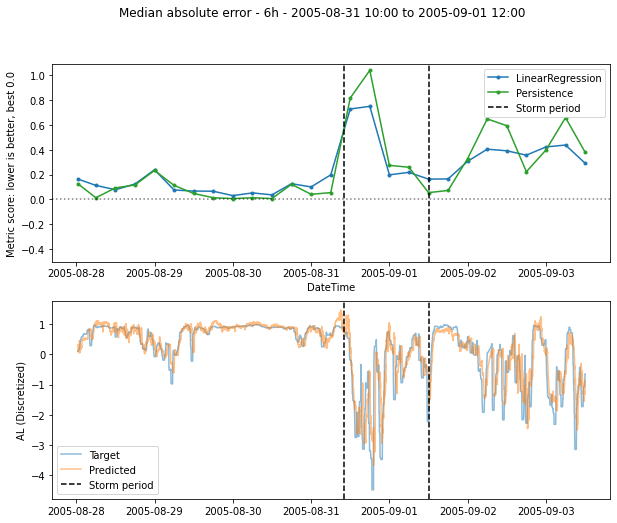

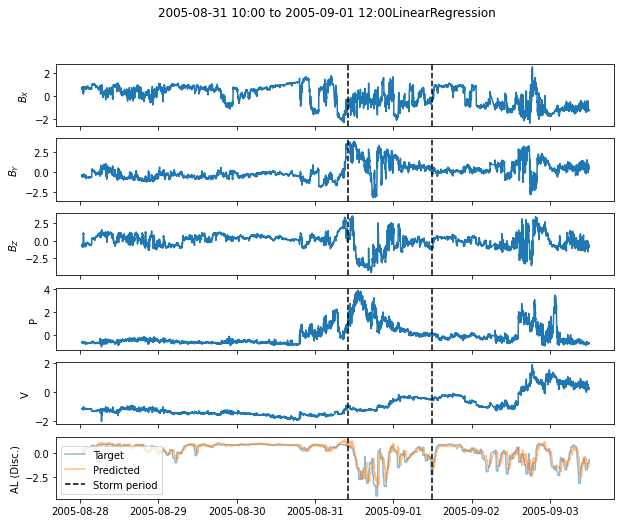

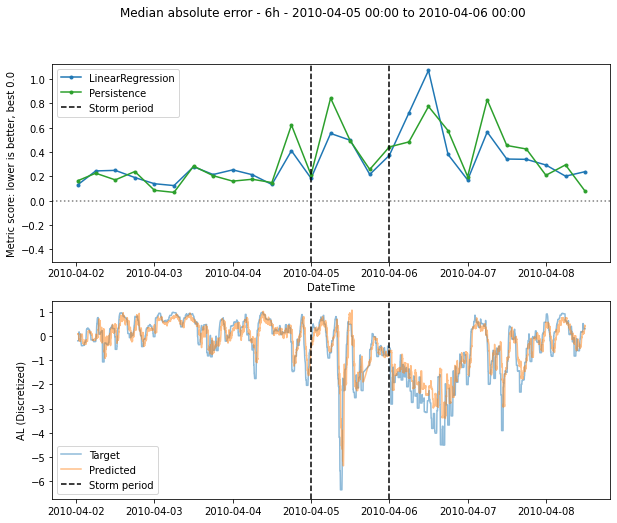

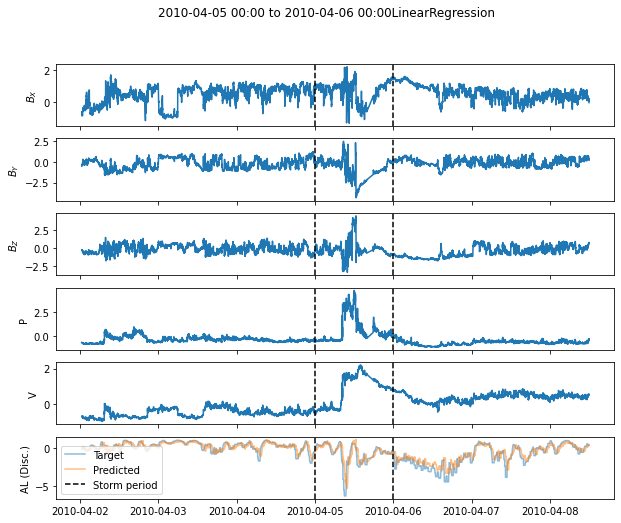

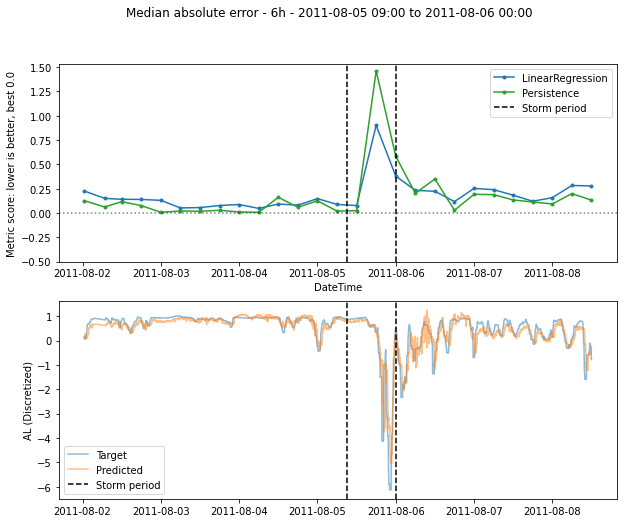

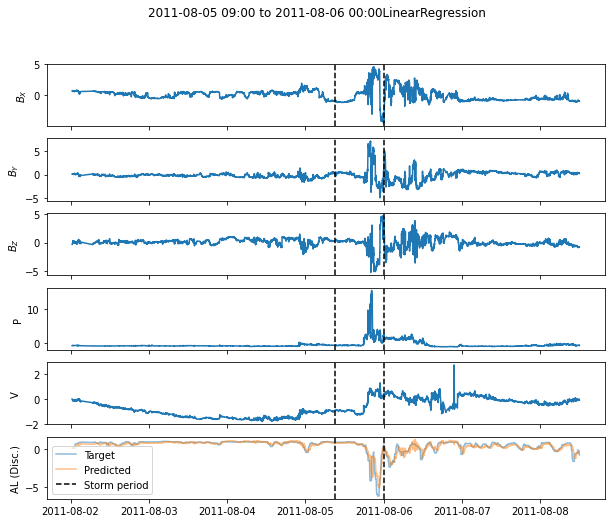

In [ ]:
def main():

    # ---------------------------------------------------------------
    # IMPORTING THE DATA

    # The method import_omni_year checks for Pickles itself
    # so we do not need to enclose this in a try statement
    data_2003 = import_omni_year(2003)

    # ---------------------------------------------------------------
    # IMPORTING OCTOBER AND NOVEMBER SEPERATELY TO ZOOM IN

    # df_oct_2003 = import_omni_month(2003, 10)
    # df_nov_2003 = import_omni_month(2003, 11)
    # df_oct_nov_2003 = pd.concat([df_oct_2003, df_nov_2003])
    # df_oct_nov_2003.to_pickle(oct_nov_pkl_path)  # store for future use

    print("All 2003 data has been loaded.")
    # print("\n2003 data:")
    # print(data_2003)

    # ---------------------------------------------------------------
    # PLOTTING THE PARAMETERS

    # plot_vals = ['B_X_GSM', 'B_Y_GSM', 'B_Z_GSM', 'n_p', 'P', 'V', 'AL']

    # for val in plot_vals:
    #    # year_title = str(val) + ' in ' + str(year)
    #    # data_2003.plot(x='DateTime', y=val, title=year_title)

    #    # oct_nov_title = str(val) + ' in October and November 2003'
    #    # df_oct_nov_2003.plot(x='DateTime', y=val, title=oct_nov_title)

    # ---------------------------------------------------------------
    # SCALER/TRANSFORMING THE DATA

    # The features we care about
    model_vals = ['B_X_GSM', 'B_Y_GSM', 'B_Z_GSM', 'n_p', 'P', 'V']

    # get just that data in a new dataframe
    df_2003 = data_2003[model_vals].copy()

    # get the AL values separately, again in a new df/series
    raw_AL = data_2003['AL'].copy()

    # ---------------------------------------------------------------
    # PERSISTENCE TIME HISTORY OF AL

    # Roll right, 30 minutes.
    # E.g. 12:00-12:30 -> 12:30, 12:01-12:31 -> 12:31
    pers_AL = raw_AL.copy()
    pers_AL = pers_AL.rolling(30).min()

    # create a copy before shifting - this is for persistence model later
    disc_AL = pers_AL.copy()

    # now, for our y/target data, we do a roll left by shifting
    # e.g. 12:00 <- 12:00-12:30, 12:01 <- 12:01-12:31
    disc_AL = disc_AL.shift(-30)

    # ---------------------------------------------------------------
    # SOLUTION TO NAN ISSUES FROM TIMESHIFTING

    # drop the nans in the last 30 elements of the discretized AL
    disc_AL.dropna(axis='index', how='any', inplace=True)

    # now, drop the last 30 minutes of all the other data so shapes stay equal
    df_2003.drop(df_2003.tail(30).index, inplace=True)
    pers_AL.drop(pers_AL.tail(30).index, inplace=True)
    raw_AL.drop(raw_AL.tail(30).index, inplace=True)

    # for the persistence model, we do the same, but they'll drop from head
    pers_AL.dropna(axis='index', how='any', inplace=True)

    # drop the beginning 29 minutes of all other data to match (why 29? idk)
    df_2003.drop(df_2003.head(29).index, inplace=True)
    disc_AL.drop(disc_AL.head(29).index, inplace=True)
    raw_AL.drop(raw_AL.head(29).index, inplace=True)

    # ---------------------------------------------------------------
    # ADD PERSISTENCE AS A FEATURE TO THE X ARRAY
    df_2003.insert(6, "AL_hist", pers_AL.copy())
    model_vals.append("AL_hist")

    # take cols and index for remaking DF after scaling
    df_index = df_2003.index

    # ---------------------------------------------------------------
    # # CORRELATION MATRIX BEFORE SCALER

    # # add disc AL
    # df_2003.insert(7, "disc_AL", disc_AL)

    # # This is obsolete, but commented here as reminder of current state of
    # # the dataframes
    # # corr_pars = ['B_X_GSM', 'B_Y_GSM', 'B_Z_GSM', 'n_p', 'P', 'V',
    #              # 'AL_hist', 'disc_AL']

    corr_abcd = df_2003.corr()

    # print("\nCorrelation matrix before standardization:\n")
    # print(df_2003.corr())

    # # print("\nCorrelation matrix for October & November 2003\n")
    # # corr_oct_nov_2003 = df_oct_nov_2003[plot_vals].corr()
    # # print(corr_oct_nov_2003)

    # # remove disc AL
    # df_2003 = df_2003.drop(["disc_AL"], axis=1)

    # ---------------------------------------------------------------
    # SCALE THE MAIN FEATURES

    # fit the scaler, then transform the features
    X_scaler = StandardScaler()
    X_scaler = X_scaler.fit(df_2003)
    X_scaled = X_scaler.transform(df_2003)

    # need to add it back into a DF
    df_2003 = pd.DataFrame(X_scaled, columns=model_vals, index=df_index)
    print("\n2003 features have been scaled.")

    # scale AL. We need to scale the discrete AL, and the raw AL
    y_scaler = StandardScaler()

    # reshape because StandardScaler needs (n_samples, n_features)
    disc_AL = disc_AL.to_numpy().reshape(-1, 1)
    raw_AL = raw_AL.to_numpy().reshape(-1, 1)

    # fit the scaler to the data
    y_scaler = y_scaler.fit(disc_AL)

    # get our newly scaled y values
    y_scaled = y_scaler.transform(disc_AL)
    raw_scaled = y_scaler.transform(raw_AL)

    # need to add it back into a DF
    disc_AL = pd.DataFrame(y_scaled, columns=['disc_AL'], index=df_index)
    raw_AL = pd.DataFrame(raw_scaled, columns=['raw_AL'], index=df_index)

    print("2003 AL has been scaled.")

    # ---------------------------------------------------------------
    # # CORR AFTER STANDARDISATION

    # # Add AL back in to the df
    # df_2003.insert(7, "disc_AL", disc_AL)

    # print("\nCorrelation matrix after standardization:\n")
    # print(df_2003.corr())

    # # drop AL again, don't want it as a feature anymore
    # df_2003 = df_2003.drop(["disc_AL"], axis=1)

    # ---------------------------------------------------------------
    # # VIOLIN PLOTS
    # # to check the distributions
    # fig, ax = plt.subplots()
    # ax = sns.violinplot(data = df_2003)
    # _ = ax.set_xticklabels(df_2003.keys(), rotation=90)
    # ax.set_title('Violin plot of df_2003')
    # ax.set_xlabel('Feature')
    # ax.set_ylabel('Normalized')

    # ---------------------------------------------------------------
    # # # MUTUAL INFORMATION

    # print("\nMUTUAL INFORMATION:")

    # # 1 year data crashes. Lets use 1 week, centred on 24h storm
    # storm_dt = datetime.datetime(2003, 9, 7, 0, 0, 0)  # start of storm
    # start_dt = storm_dt - datetime.timedelta(days=3)  # start of week: -3d
    # end_dt = storm_dt + datetime.timedelta(days=4)  # end of week: +4d

    # # make copy so we cant break anything
    # mi_2003 = df_2003.copy()

    # # reinsert AL for consistent NaN drop
    # mi_2003.insert(7, 'disc_AL', disc_AL)

    # # narrow to week
    # mi_2003 = mi_2003.loc[start_dt:end_dt]

    # # drop NaNs, MI doesn't like them
    # mi_2003.dropna(axis='index', how='any', inplace=True)

    # mi_AL = mi_2003['disc_AL']
    # mi_2003 = mi_2003.drop(['disc_AL'], axis=1)

    # print("\nExample scenario: n_p and P should have high MI:")
    # print(mutual_info_regression(
    #     mi_2003['P'].to_numpy().reshape(-1, 1), mi_2003['n_p']))

    # print("Discrete AL vs", model_vals, ":")
    # print(mutual_info_regression(mi_2003, mi_AL))

    # for i, feature in enumerate(model_vals):
    #     print("\nMutual information for", feature, "vs the others:")
    #     feature_array = model_vals.copy()
    #     feature_array = np.delete(feature_array, i)
    #     big_df = mi_2003.copy()
    #     big_df = big_df.drop([feature], axis=1)
    #     big_df = big_df.to_numpy()
    #     small_df = mi_2003[feature]
    #     small_df = small_df.to_numpy()
    #     print(feature_array)
    #     print(mutual_info_regression(big_df, small_df))


    # ---------------------------------------------------------------
    # REMOVING UNNEEDED PARAMETERS

    # removing n_p - in the words of Mayur
    # "by far weakest correlation with AL and a strong correlation with P"
    df_2003 = df_2003.drop(["n_p"], axis=1)

    # ---------------------------------------------------------------
    # INTERPOLATING GAPS

    # to make the indexes match, we're gonna combine the whole damn thing
    # and chuck it all through interpolator: df_2003 + disc_AL + raw_AL
    df_2003.insert(5, "disc_AL", disc_AL)
    df_2003.insert(6, "raw_AL", raw_AL)

    # run the interpolation
    df_2003 = storm_interpolator(df_2003)

    print("\n2003 features interpolated.")

    # seperate these two back off, drop them
    raw_AL = df_2003['raw_AL'].copy()
    disc_AL = df_2003['disc_AL'].copy()
    df_2003 = df_2003.drop(["raw_AL", "disc_AL"], axis=1)

    # ---------------------------------------------------------------
    # PLOT HISTOGRAMS:

    # hist_dir = pathlib.Path('Figures')
    # pathlib.Path(hist_dir).mkdir(exist_ok=True)

    # for i, param in enumerate(plot_vals):
    #     plt.figure()
    #     plt.hist(df_2003[param], bins=35)
    #     plt.title('Histogram of '+param+' after StandardScaler')


    # ---------------------------------------------------------------
    # KERAS PREP STEP:
    pkl_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/pkl')
    
    pkl_path = pkl_dir / ('2003_' + 'X' + '.pkl')
    df_2003.to_pickle(pkl_path)

    pkl_path = pkl_dir / ('2003_' + 'y' + '.pkl')
    disc_AL.to_pickle(pkl_path)

    # ---------------------------------------------------------------
    # TRAIN TEST SPLIT

    # Needs shape (n_samples, n_features)
    # Split the data into two parts, one for training and testing
    # 5 splits, which I think leads to 6 sets of data, 2 months each
    # first 5 (k) are training, 6th (k+1)th one is testing

    print("\nFolding the data (cross-validation):")
    tscv = TimeSeriesSplit()
    fold_counter = 0

    for train_index, test_index in tscv.split(df_2003):

        fold_counter += 1
        print("Fold", fold_counter, "...")
        # print("TRAIN:", train_index, "TEST:", test_index)  # debug
        X_train, X_test = df_2003.iloc[train_index], df_2003.iloc[test_index]
        y_train, y_test = disc_AL.iloc[train_index], disc_AL.iloc[test_index]

    print("Folding complete.")

    # ---------------------------------------------------------------
    # LINEAR REGRESSION

    # create the linear regression object
    regr = LinearRegression()

    # train it on the training data
    regr.fit(X_train, y_train)

    # ---------------------------------------------------------------
    # LINEAR REGRESSION PREDICTION AND SCORES
    y_pred = regr.predict(X_test)

    print("\nLinear Regression R^2 score (best 1.0)",
          regr.score(X_test, y_test))
    # print(r2_score(y_test, y_pred))

    # put y pred in a dataframe, just makes life easier for future
    y_test_index = y_test.index
    y_pred = pd.DataFrame(y_pred, columns=['pred_AL'], index=y_test_index)

    # ---------------------------------------------------------------
    # GET PERSISTENCE AGAIN

    pers_AL = df_2003['AL_hist'].copy()

    # ---------------------------------------------------------------
    # EVALUATING OUR MODEL VS PERSISTENCE MODEL

    ### storm_metrics used to be defined here

    metrics = ["Explained variance score",
               "Mean absolute error",
               "Mean squared error",
               "Median absolute error",
               "R2 score"]

    metrics_desc = ["higher is better, best 1.0",
                    "lower is better, best 0.0",
                    "lower is better, best 0.0",
                    "lower is better, best 0.0",
                    "higher is better, best 1.0"]

    # 2003 data - don't actually want to run metrics on this though
    # storm_metrics(y_test, pred_df, pers_AL)

    # ***************************************************************
    # ***************************************************************
    # IMPORTING THE VALIDATION STORMS, AND PREPARING THE DATA
    # ***************************************************************
    # ***************************************************************

    # ---------------------------------------------------------------
    # IMPORT VALIDATION STORMS
    # from doi:10.1002/swe.20056

    print("\nImporting the validation storms:")

    # DONT USE STORM 1 as its in the 2003 model training data!
    # storm_1 = import_storm_week(2003, 10, 29)
    storm_2 = import_storm_week(2006, 12, 14)
    storm_3 = import_storm_week(2001, 8, 31)
    storm_4 = import_storm_week(2005, 8, 31)
    storm_5 = import_storm_week(2010, 4, 5)
    storm_6 = import_storm_week(2011, 8, 5)

    storm_array = [storm_2, storm_3, storm_4, storm_5, storm_6]

    storm_str_array = ["2006-12-14 12:00 to 2006-12-16 00:00",
                       "2001-08-31 00:00 to 2001-09-01 00:00",
                       "2005-08-31 10:00 to 2005-09-01 12:00",
                       "2010-04-05 00:00 to 2010-04-06 00:00",
                       "2011-08-05 09:00 to 2011-08-06 00:00"]

    # for pickling any storms later
    storm_fname_array = ["2006-12-14",
                         "2001-08-31",
                         "2005-08-31",
                         "2010-04-05",
                         "2011-08-05"]

    storm_start_array = [datetime.datetime(2006, 12, 14, 12, 0, 0),
                         datetime.datetime(2001, 8, 31, 0, 0, 0),
                         datetime.datetime(2005, 8, 31, 10, 0, 0),
                         datetime.datetime(2010, 4, 5, 0, 0, 0),
                         datetime.datetime(2011, 8, 5, 9, 0, 0)]

    storm_end_array = [datetime.datetime(2006, 12, 16, 0, 0, 0),
                       datetime.datetime(2001, 9, 1, 0, 0, 0),
                       datetime.datetime(2005, 9, 1, 12, 0, 0),
                       datetime.datetime(2010, 4, 6, 0, 0, 0),
                       datetime.datetime(2011, 8, 6, 0, 0, 0)]

    print("Validation storms imported successfully.")

    # ---------------------------------------------------------------
    # GET FEATURES DATA AND AL
    # The features we care about - recall, no persistence yet
    model_vals = ['B_X_GSM', 'B_Y_GSM', 'B_Z_GSM', 'n_p', 'P', 'V']

    X_array = []
    raw_array = []
    for i, storm in enumerate(storm_array):
        storm_index = storm.index  # save this for reconstructing DF later
        X = storm[model_vals].copy()
        raw = storm['AL'].copy()

        # each storm's features to a df, append to X_array of dataframes
        X_array.append(pd.DataFrame(X, columns=model_vals, index=storm_index))
        raw_array.append(pd.DataFrame(raw, columns=['AL'], index=storm_index))

    # ---------------------------------------------------------------
    # PERSISTENCE AND DISCRETIZATION (is that even a word)

    disc_array = []
    pers_array = []
    df_index_array = []

    # i.e. for each storm's raw AL dataframe
    for i, raw in enumerate(raw_array):
        pers_y = raw.copy()
        pers_y = pers_y.rolling(30).min()  # roll right, 30 minute window
        disc_y = pers_y.copy()
        disc_y = disc_y.shift(-30)  # roll left for discrete AL

        # drop the 30 minutes of NaNs from the shifting
        disc_y.dropna(axis='index', how='any', inplace=True)

        # drop last 30 minutes of all others to match disc
        pers_y.drop(pers_y.tail(30).index, inplace=True)
        raw.drop(raw.tail(30).index, inplace=True)

        # for persistence, the NaNs will dorp from head
        pers_y.dropna(axis='index', how='any', inplace=True)

        # drop first 29 minutes to match
        disc_y.drop(disc_y.head(29).index, inplace=True)
        raw.drop(raw.head(29).index, inplace=True)

        # add to the arrays outside the loop
        pers_array.append(pers_y)
        disc_array.append(disc_y)
        raw_array[i] = raw.copy()

        # store the indexes for later (same for disc, pers, raw)
        df_index_array.append(disc_y.index)

    # go through the five X feature arrays
    for i, X in enumerate(X_array):

        # make them match AL
        X.drop(X.tail(30).index, inplace=True)
        X.drop(X.head(29).index, inplace=True)

        # ADD THEIR PERSISTENCE AS A FEATURE
        X.insert(6, "AL_hist", pers_array[i].to_numpy())
        X_array[i] = X.copy()

    # outside the for loop so we dont add it more than once!
    model_vals.append("AL_hist")

    # ---------------------------------------------------------------
    # STANDARD SCALING
    # we use the same scalers we used earlier. X_scaler, y_scaler, raw_scaler
    # recall X_array, raw_array. disc_array already defined, so we overwrite

    for i, storm_index in enumerate(df_index_array):

        # scale the main features
        X_scaled = X_scaler.transform(X_array[i])

        # each storm's features to a df, append to X_array of dataframes
        X_array[i] = pd.DataFrame(X_scaled,
                                  columns=model_vals, index=storm_index)

        # scale disc AL
        disc = disc_array[i].to_numpy()
        disc = disc.reshape(-1, 1)
        disc_scaled = y_scaler.transform(disc)

        # scale raw AL
        raw = raw_array[i].to_numpy()
        raw = raw.reshape(-1, 1)
        raw_scaled = y_scaler.transform(raw)

        # store in the main arrays outside the loop
        disc_array[i] = pd.DataFrame(disc_scaled, columns=['disc_AL'],
                                     index=storm_index)
        raw_array[i] = pd.DataFrame(raw_scaled, columns=['raw_AL'],
                                    index=storm_index)

    print("\nValidation storm features and AL have been scaled.")

    # ---------------------------------------------------------------
    # REMOVING N_P
    # "by far weakest correlation with AL, and a strong correlation with P"

    for i, X in enumerate(X_array):
        X = X.drop(["n_p"], axis=1)
        X_array[i] = X

    # ---------------------------------------------------------------
    # INTERPOLATE AND DROPNA IN THE TEST STORMS
    # remember, no longer need to interpolate y because its discretized

    # each storm will drop seperate dt, so store index to remake df
    interped_index_array = []

    for i, X in enumerate(X_array):

        # to make the indexes match, we're gonna combine everything
        # and chuck it all through the interpolator: df_200 + disc_AL + raw_AL
        X.insert(5, "disc_AL", disc_array[i])
        X.insert(6, "raw_AL", raw_array[i])

        # interpolate the storm
        X_array[i] = storm_interpolator(X)

        # seperate these two back off, drop them
        raw_array[i] = X_array[i]['raw_AL'].copy()
        disc_array[i] = X_array[i]['disc_AL'].copy()
        X_array[i] = X_array[i].drop(['raw_AL', 'disc_AL'], axis=1)

        # store the new index for this storm, for later
        interped_index_array.append(X_array[i].index)
    print("\nTest storms interpolated.")

    # ---------------------------------------------------------------
    # KERAS PREPATORY STEP:
    # copy out storms 0 and 2 to use as testing data. We don't want all 5!
    keras_X = [X_array[0], X_array[2]]
    keras_raw = [raw_array[0], raw_array[2]]
    keras_disc = [disc_array[0], raw_array[2]]

    pkl_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/pkl')
    
    pkl_path = pkl_dir / (storm_fname_array[0] + 'X' + '.pkl')
    keras_X[0].to_pickle(pkl_path)
    pkl_path = pkl_dir / (storm_fname_array[2] + 'X' + '.pkl')
    keras_X[1].to_pickle(pkl_path)

    pkl_path = pkl_dir / (storm_fname_array[0] + 'y' + '.pkl')
    keras_disc[0].to_pickle(pkl_path)
    pkl_path = pkl_dir / (storm_fname_array[2] + 'y' + '.pkl')
    keras_disc[1].to_pickle(pkl_path)

    # ---------------------------------------------------------------
    # PREDICTING THE DATA
    # remember we fitted the LinearRegression object regr on 2003 data

    y_pred_array = []
    for i, X in enumerate(X_array):
        prediction = regr.predict(X)
        pred_y = pd.DataFrame(
            prediction, columns=["pred_AL"], index=interped_index_array[i])
        y_pred_array.append(pred_y)

    # ---------------------------------------------------------------
    # CHUNKING STORMS
    chunk_res = '6h'

    # will store the array of chunks for each of the storms
    chunks_array = []

    print("\nChunking storms:")

    for i in range(0, len(storm_array)):
        print("Chunking the week around storm", storm_str_array[i])

        # call the storm_chunker function to get array of chunks
        chunks_array.append(
            storm_chunker(disc_array[i], y_pred_array[i],
                          X_array[i]['AL_hist'], resolution=chunk_res))

    print("Validation storms have been chunked.")

    # ---------------------------------------------------------------
    # CALCULATING THE METRICS FOR EACH CHUNK

    # iterate through each storm
    for i, storm in enumerate(chunks_array):

        metrics_array = [[], [], [], [], [], [], [], [], [], []]

        # index array to plot the metric against
        index_array = []

        # for each chunk
        for chunk in storm:

            # run the metrics
            if (len(chunk) != 0):
                temp_metrics = storm_metrics(
                    chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

                # append it into our metrics array
                for j in range(0, len(temp_metrics)):
                    metrics_array[j].append(temp_metrics[j])

                # get just index[0] as we're appending to a whole array
                index_array.append(chunk['disc_AL'].index[0].to_numpy())

            else:
                raise Exception("It's all gone a bit J.G. Ballard out there.")

        # OKAY lets get plotting for each metric!
        for j in range(3, 4):

            # this deals with model->pers->model->pers layout of metrics array
            a = 2*j
            b = a+1

            fig, axs = plt.subplots(2, sharex=False)
            fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                         + storm_str_array[i])

            axs[0].plot(index_array, metrics_array[a], label='LinearRegression',
                        marker='.')
            axs[0].plot(index_array, metrics_array[b], label='Persistence',
                        marker='.', c='tab:green')
            axs[0].axvline(storm_start_array[i], c='k', ls='--',
                           label='Storm period')
            axs[0].axvline(storm_end_array[i], c='k', ls='--')
            axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
            axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
            axs[0].set_xlabel('DateTime')

            # get the ylim so we can check if the default is okay
            old_ylim = axs[0].get_ylim()
            new_low = old_ylim[0]
            new_top = old_ylim[1]

            if (new_low <= -10):
                new_low = -10

            if (new_top >= 10):
                new_top = 10

            # if a best 1.0 metric, no need to go above 2
            if j == 0 or j == 4:
                new_top = 2
                new_low = -8
                axs[0].set_yticks(np.arange(-8, 3, step=1))

            # if a best 0.0 metric, no need to go below -0.5
            if j == 1 or j == 2 or j == 3:
                new_low = -0.5

            # set the ylim again
            axs[0].set_ylim((new_low, new_top))

            # generate the legend, auto-location
            axs[0].legend(loc='best')

            # the subplot - disc AL vs raw AL vs persistence AL
            start = index_array[0]
            end = index_array[-1]

            axs[1].plot(disc_array[i].loc[start:end], label='Target', alpha=0.5)
            axs[1].plot(y_pred_array[i].loc[start:end], alpha=0.5, label='Predicted')
            axs[1].set_ylabel('AL (Discretized)')
            axs[1].axvline(storm_start_array[i], c='k', ls='--',
                           label='Storm period')
            axs[1].axvline(storm_end_array[i], c='k', ls='--')

            axs[1].legend(loc='best')


        # # NEW PLOTS FOR PPT
        start = index_array[0]
        end = index_array[-1]
        
        fig, axs = plt.subplots(6, sharex=True)
        fig.suptitle(storm_str_array[i] + "LinearRegression")
        # print(X_array[i])
        axs[0].plot(X_array[i]['B_X_GSM'].loc[start:end], label='B_X_GSM')
        axs[0].set_ylabel('$B_X$')

        axs[1].plot(X_array[i]['B_Y_GSM'].loc[start:end], label='B_Y_GSM')
        axs[1].set_ylabel('$B_Y$')
        
        axs[2].plot(X_array[i]['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
        axs[2].set_ylabel('$B_Z$')

        axs[3].plot(X_array[i]['P'].loc[start:end], label='P')
        axs[3].set_ylabel('P')
        
        axs[4].plot(X_array[i]['V'].loc[start:end], label='V')
        axs[4].set_ylabel('V')

        axs[5].plot(disc_array[i].loc[start:end], alpha=0.5, label='Target')
        axs[5].plot(y_pred_array[i].loc[start:end], alpha=0.5, label='Predicted')
        axs[5].set_ylabel('AL (Disc.)')

        for q in range(0,6):
            axs[q].axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
            axs[q].axvline(storm_end_array[i], c='k', ls='--')

        axs[5].legend(loc='best')
    
    plt.show()

    return corr_abcd


corr_abcd = main()

# Correlation and Mutual Information plots

In [ ]:
# # Matplotlib commands sometimes need to be run in their own cell/run twice
# mpl.rcParams['figure.figsize'] = (8, 8)
# mpl.rcParams['axes.grid'] = False

# axis_labs = ['a', 'B$_x$', 'B$_y$', 'B$_z$', 'n$_p$', 'P', 'V', 'AL_hist'] 
# mi_mat = [[np.nan, 0.19723296, 0.17716452, 0.33936856, 0.35180458, 0.50392501, 0.40318302],
#  [0.19732252, np.nan, 0.10912805, 0.23352299, 0.29740217, 0.35517414, 0.33103931],
#  [0.17678116, 0.11008212, np.nan, 0.19020915, 0.28798700, 0.30033485, 0.26086014],
#  [0.33962286, 0.23266210, 0.18906539, np.nan, 1.22493096, 0.71513641, 0.58327303],
#  [0.35240924, 0.29941764, 0.28785239, 1.21913086, np.nan, 0.78534686, 0.62257512],
#  [0.50339362, 0.35413284, 0.30012873, 0.71628928, 0.78710338, np.nan, 1.25354420],
#  [0.40334913, 0.33005536, 0.26001978, 0.58331699, 0.62023343, 1.24988722, np.nan]]

# current_cmap = mpl.cm.viridis
# current_cmap.set_bad(color='black')

# fig, ax = plt.subplots(1)
# img = ax.imshow(mi_mat, origin='lower', cmap=current_cmap)

# ax.set_xticklabels(axis_labs)
# ax.set_yticklabels(axis_labs)

# ax.set_title("Mutual Information: Features vs. features")
# for (i, j), z in np.ndenumerate(mi_mat):
#     # print(j)
#     # print(z)
#     # print(axis_labs[j+1])
#     if i==j:
#         ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='black')
#     elif j==4 and i==3 or j==3 and i==4 or j==6 and i==5 or j==5 and i==6:
#         ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='black')
#     else:
#         ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='white')

# plt.show()

# ###

# axis_labs = ['a', 'B$_x$', 'B$_y$', 'B$_z$', 'n$_p$', 'P', 'V', 'AL_hist']
# mi_mat = [[0.40176237, 0.32789025, 0.34702774, 0.58152505, 0.61873087, 1.2512765, 2.80311561]]
# fig, ax = plt.subplots(1)
# img = ax.imshow(mi_mat, origin='lower', cmap=current_cmap)
# ax.set_xticklabels(axis_labs)
# ax.set_yticklabels([])
# ax.set_yticks([])

# ax.set_title("Mutual Information: Target (disc. AL) vs. features")
# for (i, j), z in np.ndenumerate(mi_mat):
#     # print(j)
#     # print(z)
#     # print(axis_labs[j+1])
  
#     ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='white')
#     if j == 6:
#         ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='black')

# plt.show()

# ###

# def pd_fill_diagonal(df_matrix, value=0): 
#     mat = df_matrix.values
#     n = mat.shape[0]
#     i = df_matrix.index
#     c = df_matrix.columns
#     mat[range(n), range(n)] = np.nan
#     return pd.DataFrame(mat, index=i, columns=c)

# corr_dcba = pd_fill_diagonal(corr_abcd)
# current_cmap = mpl.cm.coolwarm
# current_cmap.set_bad(color='black')
# corr_dcba.style.background_gradient(cmap=current_cmap, axis=None)

# TensorFlow

## Single Timestep

In [ ]:
class WindowGenerator():
    # Inspired by Andy Smith's modifications to exclude labels from inputs
    
    def __init__(self, 
                 input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        ####Marking feature column so it isnt included
        # self.feature_indices = {name: i for i, name in enumerate(train_df.columns) if name not in self.label_columns}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        ### Original
        # inputs = features[:, self.input_slice, :]
        ### Adjusted to remove target (can work for >1 target too)
        inputs = features[:, self.input_slice, :-1]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=1440,)

        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [ ]:
# for pickling any storms later
storm_fname_array = ["2006-12-14",
                    "2001-08-31",
                    "2005-08-31",
                    "2010-04-05",
                    "2011-08-05"]

storm_start_array = [datetime.datetime(2006, 12, 14, 12, 0, 0),
                    datetime.datetime(2001, 8, 31, 0, 0, 0),
                    datetime.datetime(2005, 8, 31, 10, 0, 0),
                    datetime.datetime(2010, 4, 5, 0, 0, 0),
                    datetime.datetime(2011, 8, 5, 9, 0, 0)]

storm_end_array = [datetime.datetime(2006, 12, 16, 0, 0, 0),
                    datetime.datetime(2001, 9, 1, 0, 0, 0),
                    datetime.datetime(2005, 9, 1, 12, 0, 0),
                    datetime.datetime(2010, 4, 6, 0, 0, 0),
                    datetime.datetime(2011, 8, 6, 0, 0, 0)]

pkl_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/pkl')

# ---------------------------------------------------------------
# LOAD IN THE DATA
pkl_path = pkl_dir / '2003_X.pkl'
X_2003 = pd.read_pickle(pkl_path)
pkl_path = pkl_dir / '2003_y.pkl'
y_2003 = pd.read_pickle(pkl_path)

X_2003 = X_2003[['B_Z_GSM', 'P', 'V', 'AL_hist']]

pkl_path = pkl_dir / (storm_fname_array[0] + 'X.pkl')
X1 = pd.read_pickle(pkl_path)
pkl_path = pkl_dir / (storm_fname_array[2] + 'X.pkl')
X2 = pd.read_pickle(pkl_path)

X1 = X1[['B_Z_GSM', 'P', 'V', 'AL_hist']]
X2 = X2[['B_Z_GSM', 'P', 'V', 'AL_hist']]

pkl_path = pkl_dir / (storm_fname_array[0] + 'y.pkl')
y1 = pd.read_pickle(pkl_path)
pkl_path = pkl_dir / (storm_fname_array[2] + 'y.pkl')
y2 = pd.read_pickle(pkl_path)

# ---------------------------------------------------------------
# TRAIN TEST SPLIT

dt_start_train = datetime.datetime(2003, 1, 1, 0, 0)
dt_end_train = datetime.datetime(2003, 9, 30, 23, 59)

dt_start_test = datetime.datetime(2003, 10, 1, 0, 0)
dt_end_test = datetime.datetime(2003, 12, 31, 23, 59)

X_train = X_2003.loc[dt_start_train:dt_end_train]
y_train = y_2003.loc[dt_start_train:dt_end_train]
X_test = X_2003.loc[dt_start_test:dt_end_test]
y_test = y_2003.loc[dt_start_test:dt_end_test]

# Validation: X1, y1, X2, y2. Already sorted as we use the whole year

# We need the y in the same array as X now.
# Remember train/val/test not train/test/val, just to keep things confusing
X_train.insert(4, "disc_AL", y_train)
train_df = X_train
X_test.insert(4, "disc_AL", y_test)
val_df = X_test

# This is what we used to call validation
X1.insert(4, "disc_AL", y1)
test_1 = X1
X2.insert(4, "disc_AL", y2)
test_2 = X2

column_indices = {name: i for i, name in enumerate(train_df.columns)}

# ---------------------------------------------------------------
# SINGLE STEP WINDOW

# TODO: Might change this to have shuffle=True for TEST ONLY later
single_step_window = WindowGenerator(train_df=train_df, val_df=val_df,
                                        test_df=test_1, input_width=1, 
                                        label_width=1, shift=1,
                                        label_columns=['disc_AL'])


print(single_step_window, "\n")

for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

for example_inputs, example_labels in single_step_window.val.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

for example_inputs, example_labels in single_step_window.test.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

# Dictionaries to store these in
val_performance = {}
performance = {}


# model save directory
model_dir = pathlib.Path('/content/drive/My Drive/MSSL_DATA/model')

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['disc_AL'] 

Inputs shape (batch, time, features): (1440, 1, 4)
Labels shape (batch, time, features): (1440, 1, 1)
Inputs shape (batch, time, features): (1440, 1, 4)
Labels shape (batch, time, features): (1440, 1, 1)
Inputs shape (batch, time, features): (1440, 1, 4)
Labels shape (batch, time, features): (1440, 1, 1)


### Linear Network

Input shape: (1440, 1, 4)
Output shape: (1440, 1, 1)
Epoch 1/100
271/271 [==============================] - 14s 42ms/step - loss: 0.2263 - mean_absolute_error: 0.3346 - val_loss: 0.4156 - val_mean_absolute_error: 0.3853
Epoch 2/100
271/271 [==============================] - 9s 34ms/step - loss: 0.2097 - mean_absolute_error: 0.3171 - val_loss: 0.4113 - val_mean_absolute_error: 0.3797
Epoch 3/100
271/271 [==============================] - 9s 34ms/step - loss: 0.2047 - mean_absolute_error: 0.3113 - val_loss: 0.4097 - val_mean_absolute_error: 0.3766
Epoch 4/100
271/271 [==============================] - 9s 34ms/step - loss: 0.2019 - mean_absolute_error: 0.3079 - val_loss: 0.4092 - val_mean_absolute_error: 0.3750
Epoch 5/100
271/271 [==============================] - 10s 35ms/step - loss: 0.2002 - mean_absolute_error: 0.3059 - val_loss: 0.4091 - val_mean_absolute_error: 0.3742
Epoch 6/100
87/87 [==============================] - 3s 23ms/step - loss: 0.4093 - mean_absolute_error: 0.3739
dict

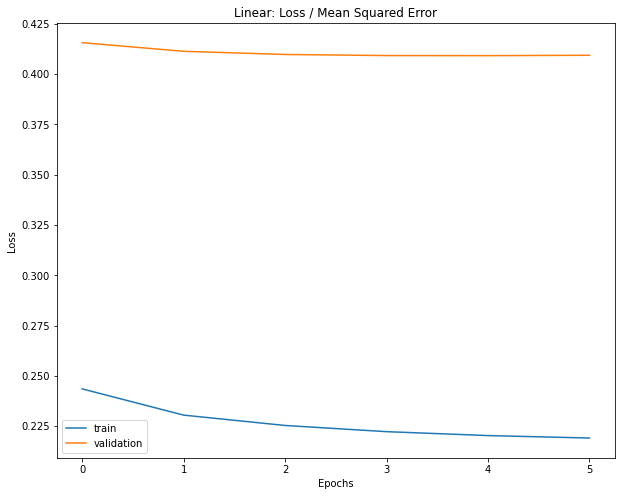

In [ ]:
# ---------------------------------------------------------------
# LINEAR MODEL
def _create_model():
    linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
    print('Input shape:', single_step_window.example[0].shape)
    print('Output shape:', linear(single_step_window.example[0]).shape)
    return linear

with strategy.scope():
    linear = _create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    linear.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    metrics=tf.metrics.MeanAbsoluteError())

history = linear.fit(single_step_window.train, epochs=100,
                validation_data=single_step_window.val,
                callbacks=[early_stopping])

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print(history.history.keys())

# plot loss during training
plt.title('Linear: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


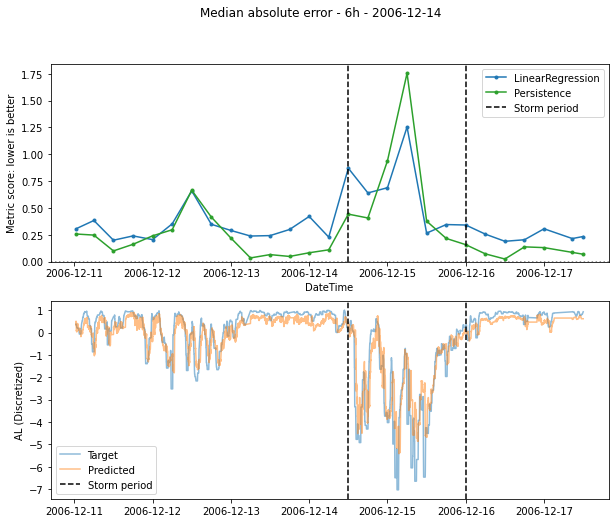

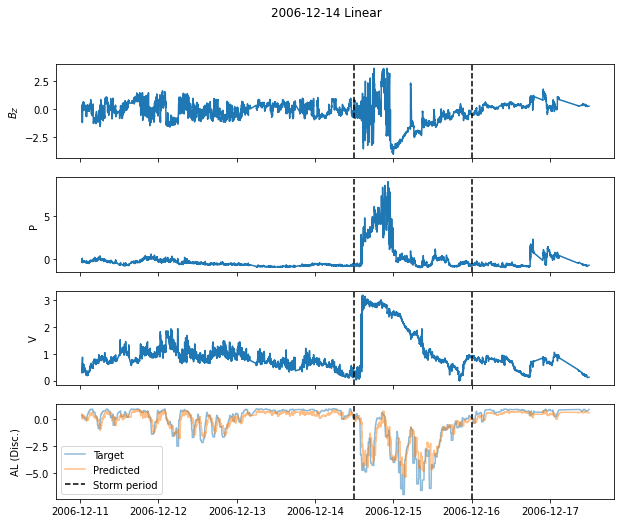

In [ ]:
predicted = linear.predict(single_step_window.test)

# Due to how linear model uses t=0 to predict t=1, we lose a datapoint!
pred_linear = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[1:].index)
# print(y1)
# print(pred_linear)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[1:], pred_linear, X1['AL_hist'].iloc[1:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception("It's all gone a bit J.G. Ballard out there.")

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='LinearRegression',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_linear.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Linear")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_linear.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

### Dense Network

Input shape: (1440, 1, 4)
Output shape: (1440, 1, 1)
Epoch 1/100
271/271 [==============================] - 15s 40ms/step - loss: 0.6567 - mean_absolute_error: 0.6599 - val_loss: 1.1730 - val_mean_absolute_error: 0.7747
Epoch 2/100
271/271 [==============================] - 10s 35ms/step - loss: 0.5863 - mean_absolute_error: 0.6180 - val_loss: 1.0525 - val_mean_absolute_error: 0.7261
Epoch 3/100
271/271 [==============================] - 9s 35ms/step - loss: 0.5211 - mean_absolute_error: 0.5801 - val_loss: 0.9308 - val_mean_absolute_error: 0.6766
Epoch 4/100
271/271 [==============================] - 10s 36ms/step - loss: 0.4597 - mean_absolute_error: 0.5425 - val_loss: 0.8140 - val_mean_absolute_error: 0.6263
Epoch 5/100
271/271 [==============================] - 9s 35ms/step - loss: 0.4011 - mean_absolute_error: 0.5040 - val_loss: 0.6991 - val_mean_absolute_error: 0.5753
Epoch 6/100
271/271 [==============================] - 9s 35ms/step - loss: 0.3487 - mean_absolute_error: 0.4661 -

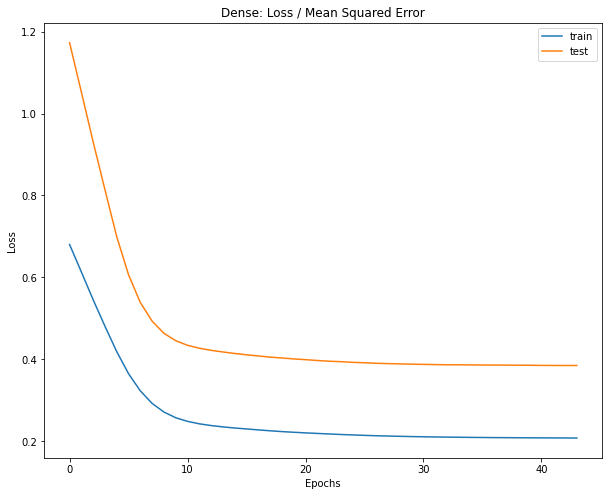

In [ ]:
# ---------------------------------------------------------------
# DENSE 

def _create_model():
    dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1)
    ])
    print('Input shape:', single_step_window.example[0].shape)
    print('Output shape:', dense(single_step_window.example[0]).shape)
    return dense

with strategy.scope():
    dense = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    dense.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=tf.metrics.MeanAbsoluteError())
    
history = dense.fit(single_step_window.train, epochs=100,
                validation_data=single_step_window.val,
                callbacks=[early_stopping])

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

# plot loss during training
plt.title('Dense: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


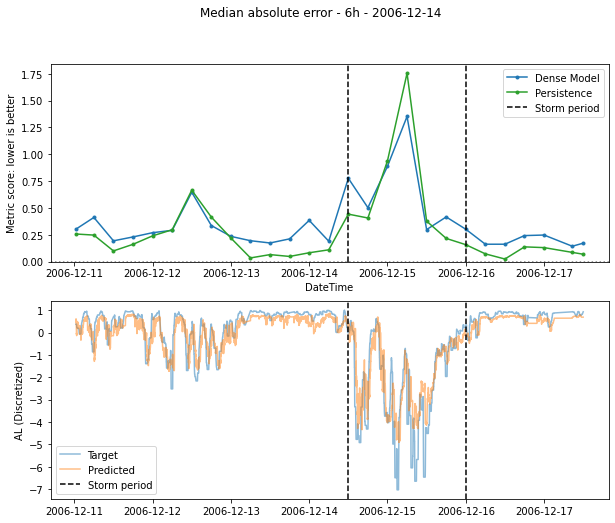

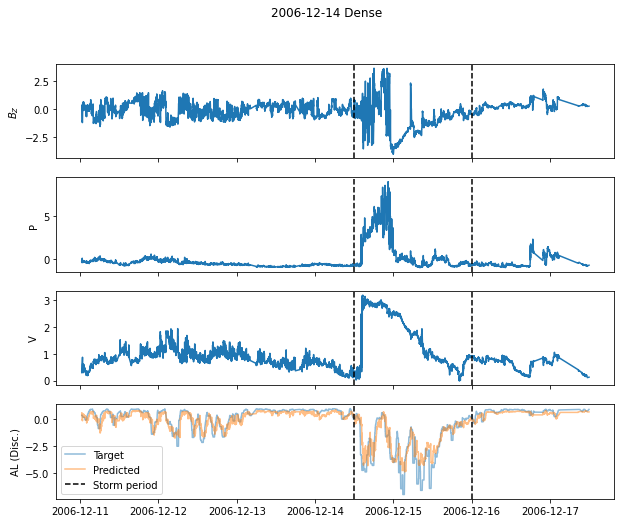

In [ ]:
predicted = dense.predict(single_step_window.test)

# Due to how linear model uses t=0 to predict t=1, we lose a datapoint!
pred_dense = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[1:].index)
# print(y1)
# print(pred_dense)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[1:], pred_dense, X1['AL_hist'].iloc[1:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception("It's all gone a bit J.G. Ballard out there.")

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Dense Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_dense.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Dense")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_dense.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

## Multiple Timestep Wide Windows

Redefining WindowGenerator here again so that we can change the batch size separately if needed.

In [ ]:
class WindowGenerator():
    # Inspired by Andy Smith's modifications to exclude labels from inputs
    
    def __init__(self, 
                 input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        ####Marking feature column so it isnt included
        # self.feature_indices = {name: i for i, name in enumerate(train_df.columns) if name not in self.label_columns}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        ### Original
        # inputs = features[:, self.input_slice, :]
        ### Adjusted to remove target (can work for >1 target too)
        inputs = features[:, self.input_slice, :-1]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=2880,)

        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [ ]:
w15 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_1,
    input_width=15,
    label_width=1,
    shift=1,
    label_columns=['disc_AL']
)

w15

Total window size: 16
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15]
Label column name(s): ['disc_AL']

In [ ]:
w30 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_1,
    input_width=30,
    label_width=1,
    shift=1,
    label_columns=['disc_AL']
)

w30

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['disc_AL']

### Multi Step Dense

#### 15 mins

Input shape: (2880, 15, 4)
Output shape: (2880, 1, 1)
Epoch 1/100
135/135 [==============================] - 14s 77ms/step - loss: 0.8274 - mean_absolute_error: 0.6809 - val_loss: 1.4103 - val_mean_absolute_error: 0.7818
Epoch 2/100
135/135 [==============================] - 9s 68ms/step - loss: 0.6022 - mean_absolute_error: 0.5646 - val_loss: 1.2284 - val_mean_absolute_error: 0.6785
Epoch 3/100
135/135 [==============================] - 9s 65ms/step - loss: 0.4977 - mean_absolute_error: 0.4859 - val_loss: 1.1396 - val_mean_absolute_error: 0.6155
Epoch 4/100
135/135 [==============================] - 9s 68ms/step - loss: 0.4453 - mean_absolute_error: 0.4408 - val_loss: 1.0733 - val_mean_absolute_error: 0.5810
Epoch 5/100
135/135 [==============================] - 9s 67ms/step - loss: 0.4104 - mean_absolute_error: 0.4161 - val_loss: 1.0062 - val_mean_absolute_error: 0.5556
Epoch 6/100
135/135 [==============================] - 9s 68ms/step - loss: 0.3805 - mean_absolute_error: 0.3991 - 

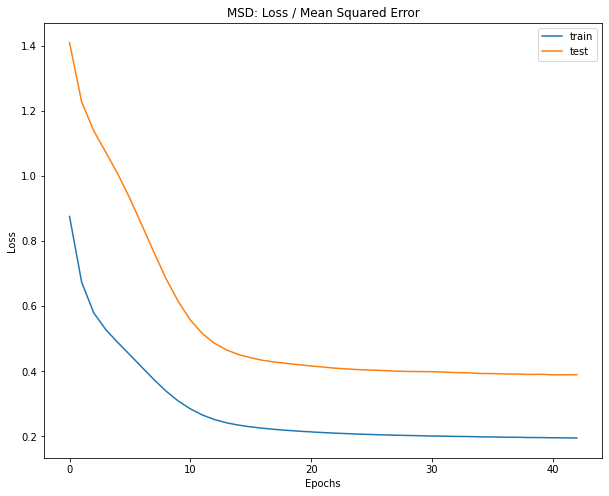

In [ ]:
def _create_model():
    multi_step_dense = tf.keras.Sequential([
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=2, activation='relu'),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ])
    print('Input shape:', w15.example[0].shape)
    print('Output shape:', multi_step_dense(w15.example[0]).shape)
    return multi_step_dense

with strategy.scope():
    msd = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    msd.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=tf.metrics.MeanAbsoluteError())
    
history = msd.fit(w15.train, epochs=100,
                validation_data=w15.val,
                callbacks=[early_stopping])

val_performance['MSD'] = msd.evaluate(w15.val)
performance['MSD'] = msd.evaluate(w15.test, verbose=0)

# plot loss during training
plt.title('MSD: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


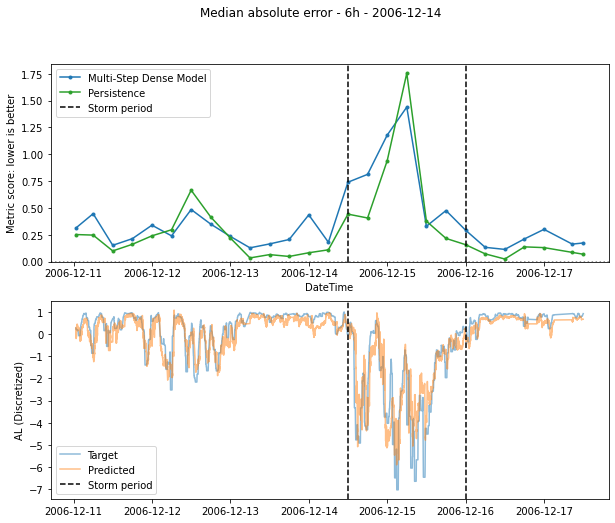

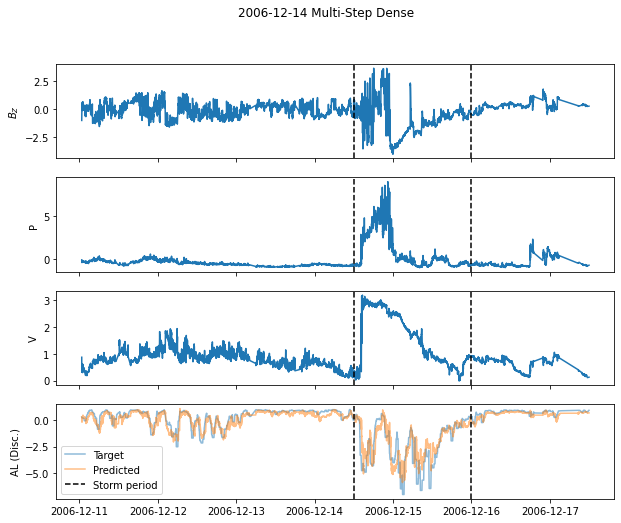

In [ ]:
predicted = msd.predict(w15.test)

# Due to W15 window, need to skip first 15
pred_msd = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[15:].index)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[15:], pred_msd, X1['AL_hist'].iloc[15:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception("It's all gone a bit J.G. Ballard out there.")

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Multi-Step Dense Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_msd.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Multi-Step Dense")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_msd.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

#### 30 minutes

Input shape: (2880, 30, 4)
Output shape: (2880, 1, 1)
Epoch 1/100
135/135 [==============================] - 14s 76ms/step - loss: 0.7929 - mean_absolute_error: 0.7285 - val_loss: 1.4052 - val_mean_absolute_error: 0.8566
Epoch 2/100
135/135 [==============================] - 9s 68ms/step - loss: 0.6945 - mean_absolute_error: 0.6761 - val_loss: 1.3064 - val_mean_absolute_error: 0.8274
Epoch 3/100
135/135 [==============================] - 9s 66ms/step - loss: 0.6556 - mean_absolute_error: 0.6578 - val_loss: 1.2229 - val_mean_absolute_error: 0.8058
Epoch 4/100
135/135 [==============================] - 9s 67ms/step - loss: 0.6230 - mean_absolute_error: 0.6440 - val_loss: 1.1127 - val_mean_absolute_error: 0.7771
Epoch 5/100
135/135 [==============================] - 10s 71ms/step - loss: 0.5807 - mean_absolute_error: 0.6264 - val_loss: 0.9621 - val_mean_absolute_error: 0.7360
Epoch 6/100
135/135 [==============================] - 9s 64ms/step - loss: 0.5313 - mean_absolute_error: 0.6050 -

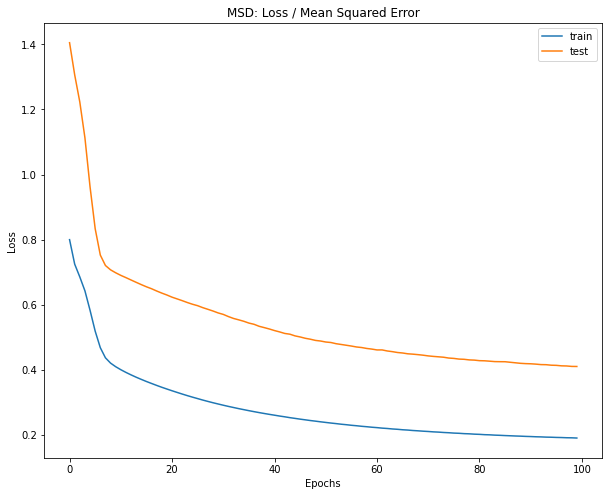

In [ ]:
def _create_model():
    multi_step_dense = tf.keras.Sequential([
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=2, activation='relu'),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ])
    print('Input shape:', w30.example[0].shape)
    print('Output shape:', multi_step_dense(w30.example[0]).shape)
    return multi_step_dense

with strategy.scope():
    msd = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    msd.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=tf.metrics.MeanAbsoluteError())
    
history = msd.fit(w30.train, epochs=100,
                validation_data=w30.val,
                callbacks=[early_stopping])

val_performance['MSD'] = msd.evaluate(w30.val)
performance['MSD'] = msd.evaluate(w30.test, verbose=0)

# plot loss during training
plt.title('MSD: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


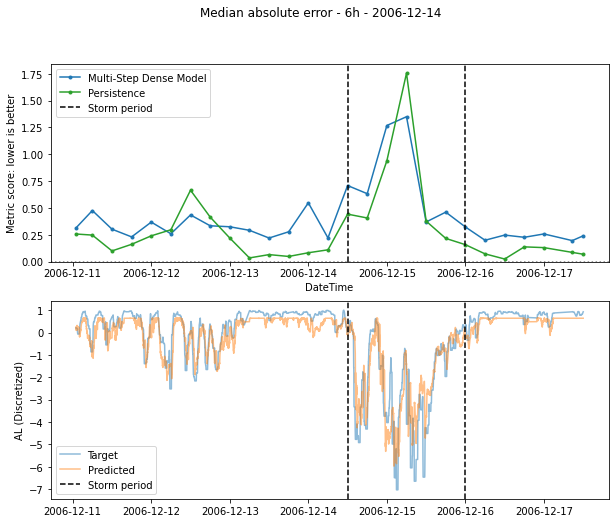

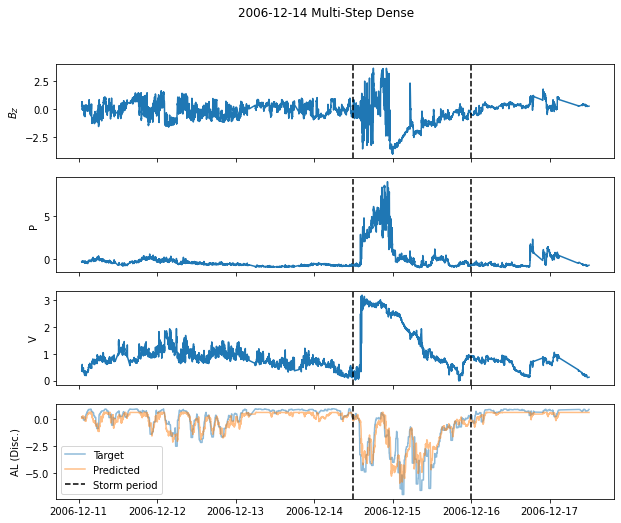

In [ ]:
predicted = msd.predict(w30.test)

# Due to W30 window, need to skip first 30
pred_msd = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[30:].index)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[30:], pred_msd, X1['AL_hist'].iloc[30:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception()

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Multi-Step Dense Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_msd.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Multi-Step Dense")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_msd.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

### Convolutional Neural Network

#### 15 mins

Conv model on `w15`
Input shape: (2880, 15, 4)
Output shape: (2880, 1, 1)
Epoch 1/100
135/135 [==============================] - 15s 80ms/step - loss: 0.5723 - mean_absolute_error: 0.5353 - val_loss: 1.1170 - val_mean_absolute_error: 0.5489
Epoch 2/100
135/135 [==============================] - 9s 68ms/step - loss: 0.4183 - mean_absolute_error: 0.3874 - val_loss: 1.0543 - val_mean_absolute_error: 0.5261
Epoch 3/100
135/135 [==============================] - 9s 67ms/step - loss: 0.3858 - mean_absolute_error: 0.3699 - val_loss: 0.9993 - val_mean_absolute_error: 0.5083
Epoch 4/100
135/135 [==============================] - 9s 70ms/step - loss: 0.3604 - mean_absolute_error: 0.3594 - val_loss: 0.9518 - val_mean_absolute_error: 0.4912
Epoch 5/100
135/135 [==============================] - 9s 65ms/step - loss: 0.3388 - mean_absolute_error: 0.3503 - val_loss: 0.9094 - val_mean_absolute_error: 0.4759
Epoch 6/100
135/135 [==============================] - 9s 67ms/step - loss: 0.3197 - mean_absol

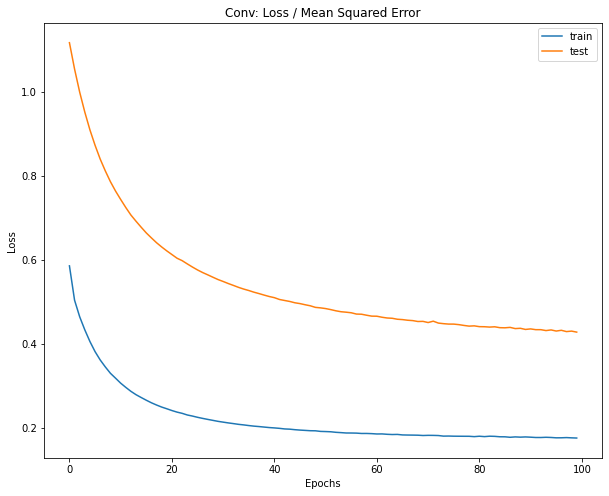

In [ ]:
# CONVOLUTIONAL NEURAL NETWORK

def _create_model():
    conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(15,), activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='relu'),
    tf.keras.layers.Dense(units=1)
    ])
    print("Conv model on `w15`")
    print('Input shape:', w15.example[0].shape)
    print('Output shape:', conv_model(w15.example[0]).shape)
    return conv_model

with strategy.scope():
    conv = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    conv.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    metrics=tf.metrics.MeanAbsoluteError())
    
history = conv.fit(w15.train, epochs=100,
                validation_data=w15.val,
                callbacks=[early_stopping])

val_performance['Conv'] = conv.evaluate(w15.val)
performance['Conv'] = conv.evaluate(w15.test, verbose=0)

# plot loss during training
plt.title('Conv: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


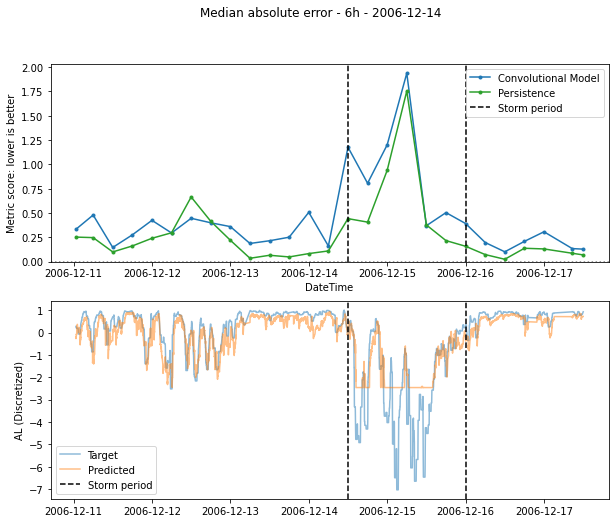

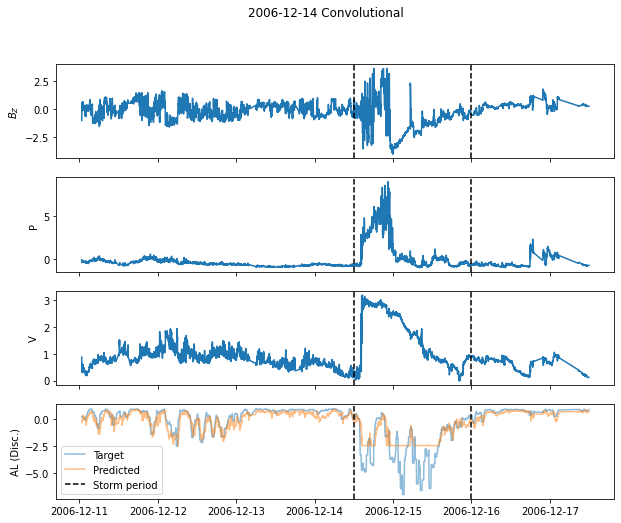

In [ ]:
predicted = conv.predict(w15.test)

# Due to W15 window, need to skip first 15
pred_conv = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[15:].index)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[15:], pred_conv, X1['AL_hist'].iloc[15:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception("It's all gone a bit J.G. Ballard out there.")

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Convolutional Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_conv.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Convolutional")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_conv.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

#### 30 mins

Conv model on `w30`
Input shape: (2880, 30, 4)
Output shape: (2880, 1, 1)
Epoch 1/100
135/135 [==============================] - 15s 83ms/step - loss: 0.6191 - mean_absolute_error: 0.6389 - val_loss: 0.8986 - val_mean_absolute_error: 0.7173
Epoch 2/100
135/135 [==============================] - 9s 66ms/step - loss: 0.4887 - mean_absolute_error: 0.5852 - val_loss: 0.7145 - val_mean_absolute_error: 0.6613
Epoch 3/100
135/135 [==============================] - 9s 65ms/step - loss: 0.4355 - mean_absolute_error: 0.5606 - val_loss: 0.6626 - val_mean_absolute_error: 0.6329
Epoch 4/100
135/135 [==============================] - 9s 68ms/step - loss: 0.3962 - mean_absolute_error: 0.5335 - val_loss: 0.6050 - val_mean_absolute_error: 0.5906
Epoch 5/100
135/135 [==============================] - 9s 68ms/step - loss: 0.3420 - mean_absolute_error: 0.4900 - val_loss: 0.5289 - val_mean_absolute_error: 0.5240
Epoch 6/100
135/135 [==============================] - 9s 69ms/step - loss: 0.2754 - mean_absol

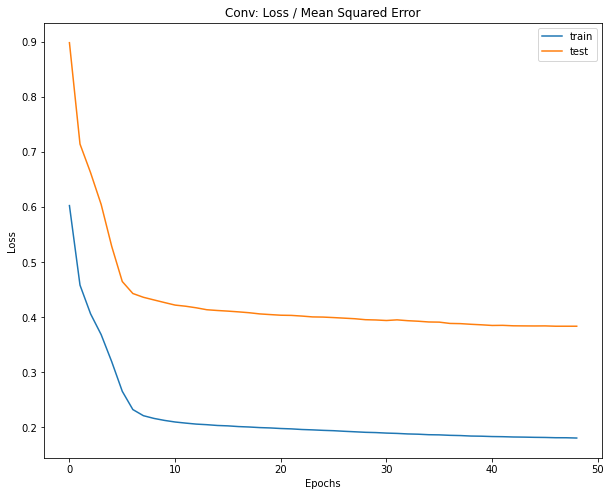

In [ ]:
# CONVOLUTIONAL NEURAL NETWORK

def _create_model():
    conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(30,), activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='relu'),
    tf.keras.layers.Dense(units=1)
    ])
    print("Conv model on `w30`")
    print('Input shape:', w30.example[0].shape)
    print('Output shape:', conv_model(w30.example[0]).shape)
    return conv_model

with strategy.scope():
    conv = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    conv.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=tf.metrics.MeanAbsoluteError())
    
history = conv.fit(w30.train, epochs=100,
                validation_data=w30.val,
                callbacks=[early_stopping])

val_performance['Conv'] = conv.evaluate(w30.val)
performance['Conv'] = conv.evaluate(w30.test, verbose=0)

# plot loss during training
plt.title('Conv: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


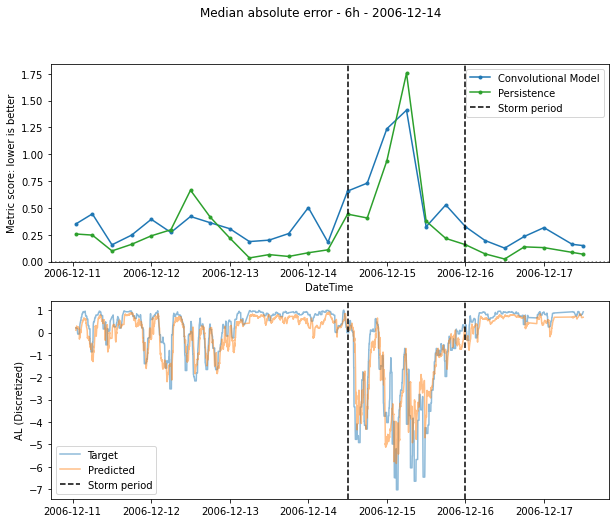

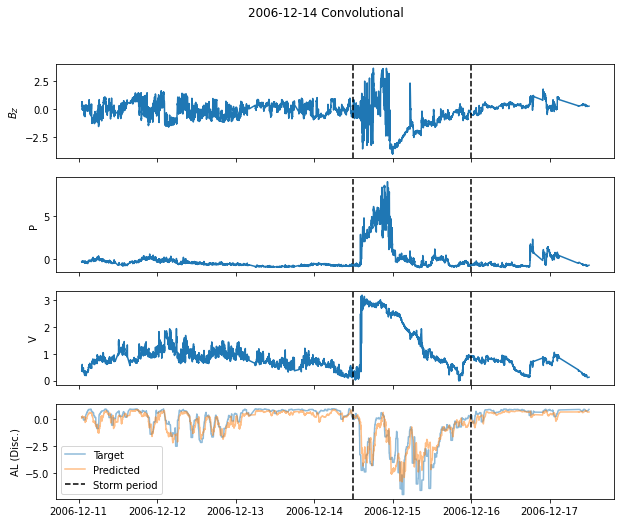

In [ ]:
predicted = conv.predict(w30.test)

# Due to W15 window, need to skip first 15
pred_conv = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[30:].index)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[30:], pred_conv, X1['AL_hist'].iloc[30:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception()

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Convolutional Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_conv.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Convolutional")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_conv.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

### LSTM Recurrent

### 15 mins

Input shape: (2880, 15, 4)
Output shape: (2880, 1)
Epoch 1/100
135/135 [==============================] - 19s 89ms/step - loss: 0.5989 - mean_absolute_error: 0.6111 - val_loss: 0.8342 - val_mean_absolute_error: 0.5595
Epoch 2/100
135/135 [==============================] - 10s 71ms/step - loss: 0.2931 - mean_absolute_error: 0.3955 - val_loss: 0.5944 - val_mean_absolute_error: 0.4132
Epoch 3/100
135/135 [==============================] - 9s 66ms/step - loss: 0.2289 - mean_absolute_error: 0.3264 - val_loss: 0.5522 - val_mean_absolute_error: 0.3982
Epoch 4/100
135/135 [==============================] - 9s 68ms/step - loss: 0.2219 - mean_absolute_error: 0.3200 - val_loss: 0.5298 - val_mean_absolute_error: 0.3927
Epoch 5/100
135/135 [==============================] - 9s 68ms/step - loss: 0.2173 - mean_absolute_error: 0.3166 - val_loss: 0.5130 - val_mean_absolute_error: 0.3884
Epoch 6/100
135/135 [==============================] - 9s 68ms/step - loss: 0.2139 - mean_absolute_error: 0.3139 - va

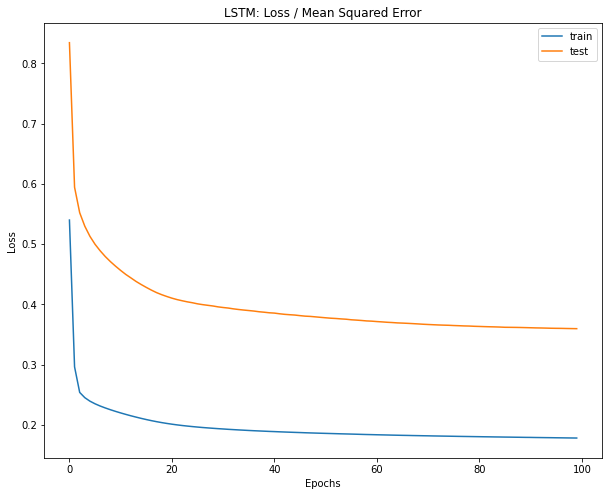

In [ ]:
# RECURRENT (LSTM) MODEL
def _create_model():
    lstm = tf.keras.models.Sequential([
    
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
    ])
    print('Input shape:', w15.example[0].shape)
    print('Output shape:', lstm(w15.example[0]).shape)
    return lstm

with strategy.scope():
    lstm = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    lstm.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=tf.metrics.MeanAbsoluteError())

history = lstm.fit(w15.train, epochs=100, 
                   validation_data=w15.val,
                   callbacks=[early_stopping])

val_performance['LSTM'] = lstm.evaluate(w15.val)
performance['LSTM'] = lstm.evaluate(w15.test, verbose=0)

# plot loss during training
plt.title('LSTM: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


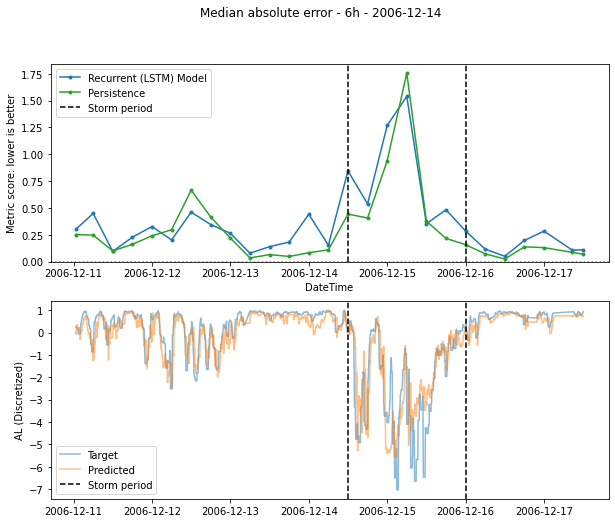

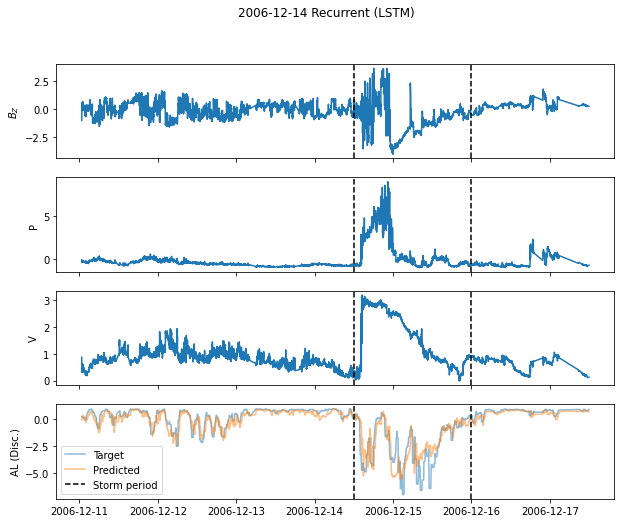

In [ ]:
predicted = lstm.predict(w15.test)

# Due to W15 window, need to skip first 15
pred_lstm = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[15:].index)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[15:], pred_lstm, X1['AL_hist'].iloc[15:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception("It's all gone a bit J.G. Ballard out there.")

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Recurrent (LSTM) Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_lstm.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Recurrent (LSTM)")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_lstm.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

In [ ]:
w30_5 = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_1,
    input_width=30,
    label_width=1,
    shift=5,
    label_columns=['disc_AL']
)

w30_5

Total window size: 35
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [34]
Label column name(s): ['disc_AL']

### 30 mins, 5 shift

Input shape: (2880, 30, 4)
Output shape: (2880, 1)
Epoch 1/100
135/135 [==============================] - 19s 87ms/step - loss: 0.6526 - mean_absolute_error: 0.6683 - val_loss: 1.0029 - val_mean_absolute_error: 0.7261
Epoch 2/100
135/135 [==============================] - 9s 69ms/step - loss: 0.4967 - mean_absolute_error: 0.5934 - val_loss: 0.8165 - val_mean_absolute_error: 0.6671
Epoch 3/100
135/135 [==============================] - 9s 67ms/step - loss: 0.4323 - mean_absolute_error: 0.5583 - val_loss: 0.7236 - val_mean_absolute_error: 0.6254
Epoch 4/100
135/135 [==============================] - 9s 66ms/step - loss: 0.3798 - mean_absolute_error: 0.5185 - val_loss: 0.6389 - val_mean_absolute_error: 0.5708
Epoch 5/100
135/135 [==============================] - 9s 69ms/step - loss: 0.3145 - mean_absolute_error: 0.4587 - val_loss: 0.5477 - val_mean_absolute_error: 0.4792
Epoch 6/100
135/135 [==============================] - 9s 70ms/step - loss: 0.2462 - mean_absolute_error: 0.3753 - val

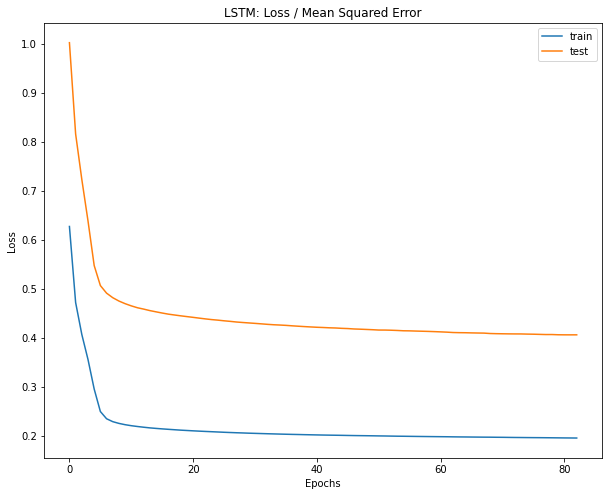

In [ ]:
# RECURRENT (LSTM) MODEL
def _create_model():
    lstm = tf.keras.models.Sequential([
    
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),

    tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    # tf.keras.layers.Dense(units=16, activation='relu'),
    
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
    ])
    print('Input shape:', w30_5.example[0].shape)
    print('Output shape:', lstm(w30_5.example[0]).shape)
    return lstm

with strategy.scope():
    lstm = _create_model()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    min_delta=0.0001)
    
    lstm.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=tf.metrics.MeanAbsoluteError())

history = lstm.fit(w30_5.train, epochs=100, 
                   validation_data=w30_5.val,
                   callbacks=[early_stopping])

val_performance['LSTM'] = lstm.evaluate(w30_5.val)
performance['LSTM'] = lstm.evaluate(w30_5.test, verbose=0)

# plot loss during training
plt.title('LSTM: Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


Chunking storms:
Chunking the week around storm 2006-12-14
Validation storm 1 has been chunked.


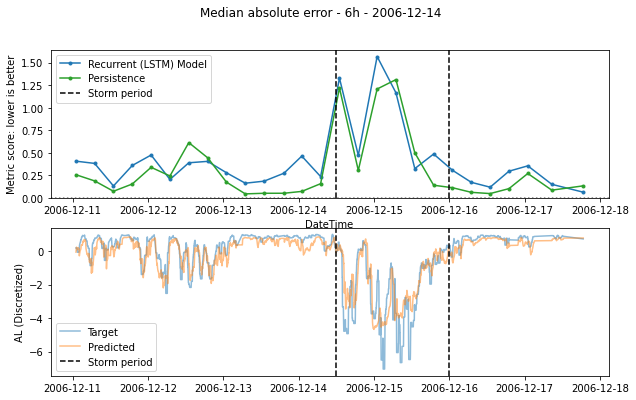

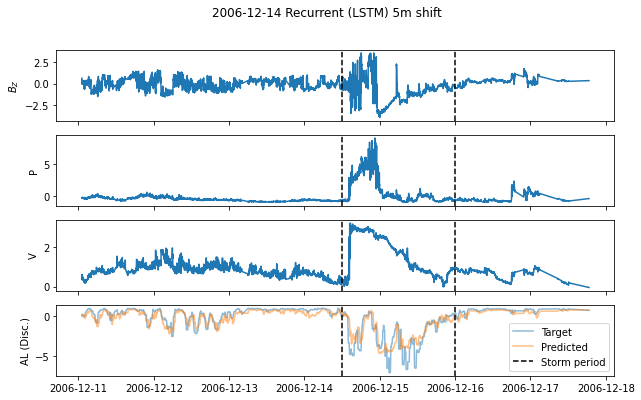

In [ ]:
predicted = lstm.predict(w30_5.test)

# Due to W15 window, need to skip first 15
pred_lstm = pd.DataFrame(predicted.reshape(1,-1)[0], columns=['pred_AL'], index=y1.iloc[34:].index)

# CHUNKING STORMS
chunk_res = '6h'

# will store the array of chunks for each of the storms
chunks_array = []

print("\nChunking storms:")

print("Chunking the week around storm", storm_fname_array[0])

# call the storm_chunker function to get array of chunks
chunks_array.append(
    storm_chunker(y1.iloc[34:], pred_lstm, X1['AL_hist'].iloc[34:], resolution=chunk_res))

print("Validation storm 1 has been chunked.")

# ---------------------------------------------------------------
# CALCULATING THE METRICS FOR EACH CHUNK

# iterate through each storm
for i, storm in enumerate(chunks_array):

    metrics_array = [[], [], [], [], [], [], [], [], [], []]

    # index array to plot the metric against
    index_array = []

    # for each chunk
    for chunk in storm:

        # run the metrics
        if (len(chunk) != 0):
            temp_metrics = storm_metrics(
                chunk['disc_AL'], chunk['pred_AL'], chunk['AL_hist'])

            # append it into our metrics array
            for j in range(0, len(temp_metrics)):
                metrics_array[j].append(temp_metrics[j])

            # get just index[0] as we're appending to a whole array
            index_array.append(chunk['disc_AL'].index[0].to_numpy())

        else:
            raise Exception("It's all gone a bit J.G. Ballard out there.")

    # OKAY lets get plotting for each metric!
    for j in range(3, 4):

        # this deals with model->pers->model->pers layout of metrics array
        a = 2*j
        b = a+1

        fig, axs = plt.subplots(2, sharex=False)
        fig.suptitle(metrics[j] + " - " + chunk_res + " - "
                        + storm_fname_array[i])

        axs[0].plot(index_array, metrics_array[a], label='Recurrent (LSTM) Model',
                    marker='.')
        axs[0].plot(index_array, metrics_array[b], label='Persistence',
                    marker='.', c='tab:green')
        axs[0].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[0].axvline(storm_end_array[i], c='k', ls='--')
        axs[0].axhline(0, c='k', alpha=0.5, ls='dotted')
        axs[0].set_ylabel('Metric score: ' + metrics_desc[j])
        axs[0].set_xlabel('DateTime')

        # get the ylim so we can check if the default is okay
        old_ylim = axs[0].get_ylim()
        new_low = old_ylim[0]
        new_top = old_ylim[1]

        if (new_low <= -10):
            new_low = -10

        if (new_top >= 10):
            new_top = 10

        # if a best 1.0 metric, no need to go above 2
        if j == 0 or j == 4:
            new_top = 2
            new_low = -8
            axs[0].set_yticks(np.arange(-8, 3, step=1))

        # if a best 0.0 metric, no need to go below -0.5
        if j == 1 or j == 2 or j == 3:
            new_low = 0.0

        # set the ylim again
        axs[0].set_ylim((new_low, new_top))

        # generate the legend, auto-location
        axs[0].legend(loc='best')

        # the subplot - disc AL vs raw AL vs persistence AL
        start = index_array[0]
        end = index_array[-1]

        axs[1].plot(y1.loc[start:end], label='Target', alpha=0.5)
        axs[1].plot(pred_lstm.loc[start:end], alpha=0.5, label='Predicted')
        axs[1].set_ylabel('AL (Discretized)')
        axs[1].axvline(storm_start_array[i], c='k', ls='--',
                        label='Storm period')
        axs[1].axvline(storm_end_array[i], c='k', ls='--')

        axs[1].legend(loc='best')


    # # # NEW PLOTS FOR PPT
    start = index_array[0]
    end = index_array[-1]
    
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(storm_fname_array[0] + " Recurrent (LSTM) 5m shift")
    # print(X1)
    
    axs[0].plot(X1['B_Z_GSM'].loc[start:end], label='B_Z_GSM')
    axs[0].set_ylabel('$B_Z$')

    axs[1].plot(X1['P'].loc[start:end], label='P')
    axs[1].set_ylabel('P')
    
    axs[2].plot(X1['V'].loc[start:end], label='V')
    axs[2].set_ylabel('V')

    axs[3].plot(y1.loc[start:end], alpha=0.5, label='Target')
    axs[3].plot(pred_lstm.loc[start:end], alpha=0.5, label='Predicted')
    axs[3].set_ylabel('AL (Disc.)')

    for ax in axs:
        ax.axvline(storm_start_array[i], c='k', ls='--', label='Storm period')
        ax.axvline(storm_end_array[i], c='k', ls='--')

    axs[3].legend(loc='best')

plt.show()

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 6)